# 1D NLSE Solver

The goal of this notebook is to solve the Nonlinear Shrodinger Equation in 1D:
\begin{equation}
    \frac{\partial A}{\partial z} = -i\frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + i\gamma |A|^2 A.
\end{equation}
The first term of RHS corresponds to the chromatic dispersion, where $\beta_2$ is group velocity dispersion, and the second term is Kerr nonlinearity. 

This can be solved numerically using split-step Fourier method:
\begin{equation}
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2}{2} (\omega)^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma |A(z, T)|^2 \Delta z}   A(z, T) \right\}  \right\} 
\end{equation}

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

# import module
from nlse import *

## Target Pulse 1: Square Wave

### Define Parameters

In [26]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 1000
lr = 1e-3

# define constraints
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


### Define Target

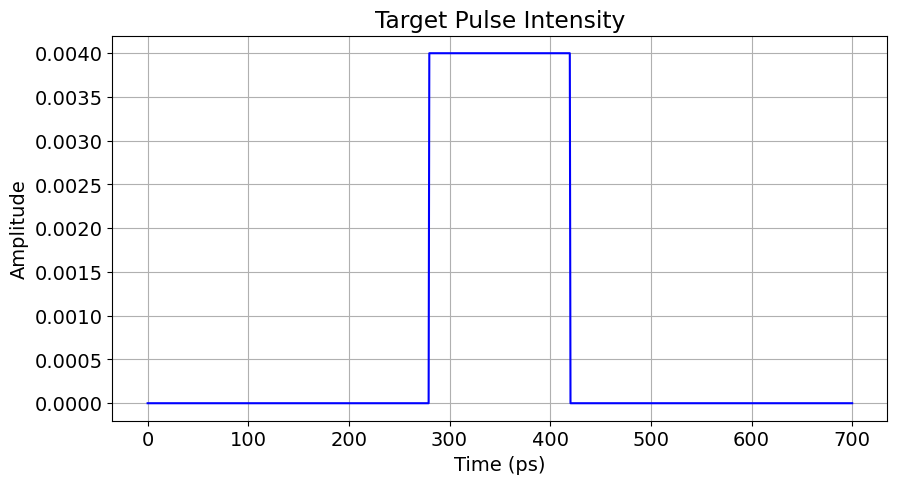

In [27]:
# define parameter of pulse
Amplitude = 0.004
width_percent = 0.2 # size in percent of the window size

# define target pulse
target_intensity = torch.zeros(Nt)
target_intensity[int(Nt/2-Nt*width_percent/2):int(Nt/2+Nt*width_percent/2)] = 1
target_intensity = target_intensity * Amplitude

# define domain of pulse
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(t, target_intensity, color='blue')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Target Pulse Intensity')
plt.grid()
plt.show()





### Define Initial Guess

In [28]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

# define mask (so that pulse is periodic)
mask = torch.zeros(Nt)
mask[int(Nt/2-Nt*mask_percent/2):int(Nt/2+Nt*mask_percent/2)] = 1

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)

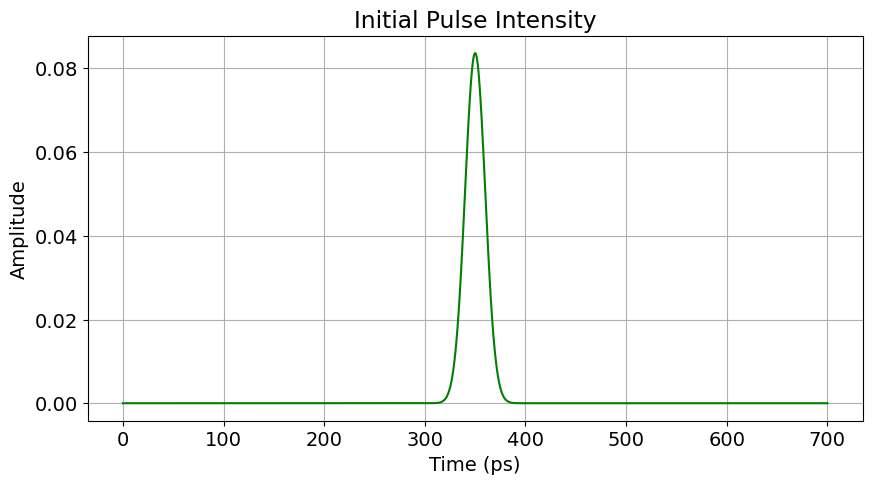

In [29]:
# plot initial pulse
plt.figure(figsize=(10, 5))
plt.plot(t, Ain.detach().numpy(), color='g')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Initial Pulse Intensity')
plt.grid()
plt.show()

### Define Model and Loss Function

In [30]:
def forward(Ain):
    Ain = Ain * mask
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

def loss_function(Aout):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(Aout)**2, target_intensity)
    
    return mse_loss

optimizer = optim.Adam([Ain], lr=lr)

### Train Model

In [31]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 2.131936298610526e-06
Iteration 50, Loss: 5.027586098549364e-07
Iteration 100, Loss: 1.2194828968858928e-07
Iteration 150, Loss: 7.494646325767462e-08
Iteration 200, Loss: 4.5561243666725204e-08
Iteration 250, Loss: 3.004781135018675e-08
Iteration 300, Loss: 2.3311580221729855e-08
Iteration 350, Loss: 1.9947506757489464e-08
Iteration 400, Loss: 1.7964234544365354e-08
Iteration 450, Loss: 1.6578123762656105e-08
Iteration 500, Loss: 1.5497549910037378e-08
Iteration 550, Loss: 1.462184773259878e-08
Iteration 600, Loss: 1.3890014471940049e-08
Iteration 650, Loss: 1.3256204134393101e-08
Iteration 700, Loss: 1.2689094219808794e-08
Iteration 750, Loss: 1.2167787666328422e-08
Iteration 800, Loss: 1.1680606704089769e-08
Iteration 850, Loss: 1.1223333373777677e-08
Iteration 900, Loss: 1.0793895555138988e-08
Iteration 950, Loss: 1.0389033633373401e-08


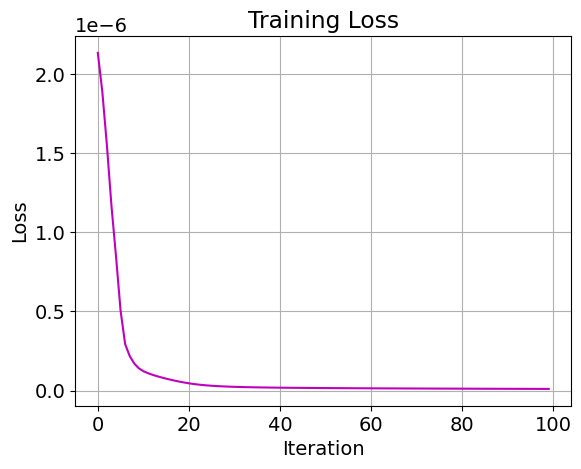

In [32]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

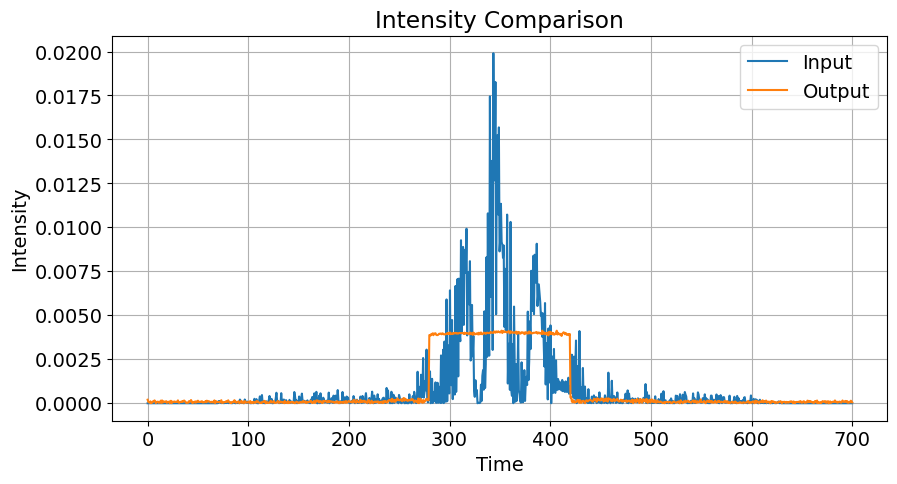

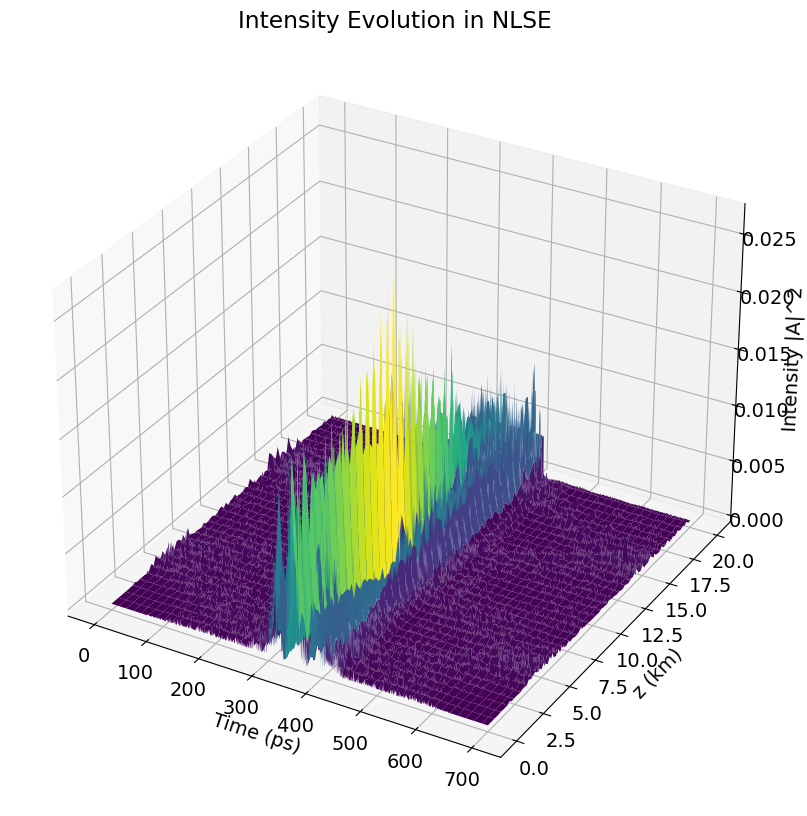

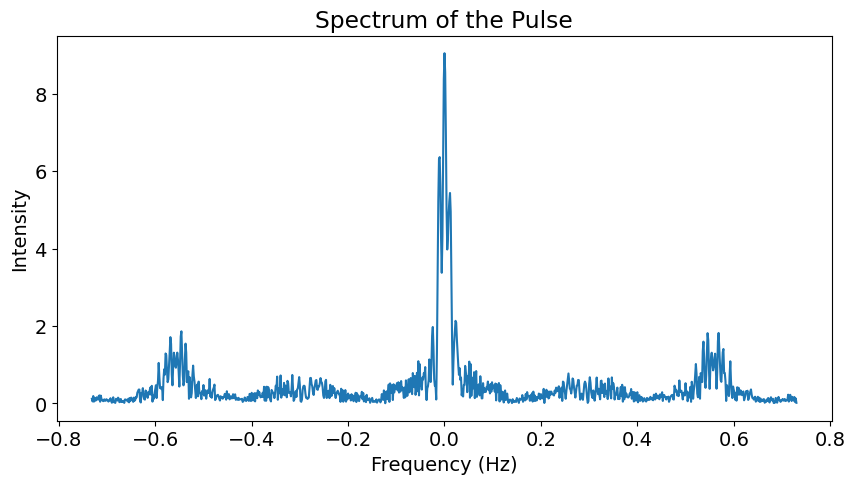

In [33]:
# plot comparison between input and output
Ain_masked = Ain * mask
plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectrum
plot_spectrum(Aout, Nt, Lt)

## Target Pulse 1: Square Wave (Improved)

Current problem with 1D square wave is that in evolving the wave the proposed solution results in nonperiodic (non-zero boundary value) solutions. One idea to constrain the proposed input to not have this behavior is to introduce a **non-physical** penalty in the loss function, penalizing such non-physical solutions. Similarly to the soliton task, we can improve the performance by onsidering also intermediate pulses (i.e. not only input and output).

$$\mathcal{L}_{pen} = w_{pen} \sum sum(mask_{pen} * A_i)$$

### Define Parameters

In [3]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 9000
lr = 1e-3

w_mse = 1.0
w_pen = 1e5

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


### Define Target

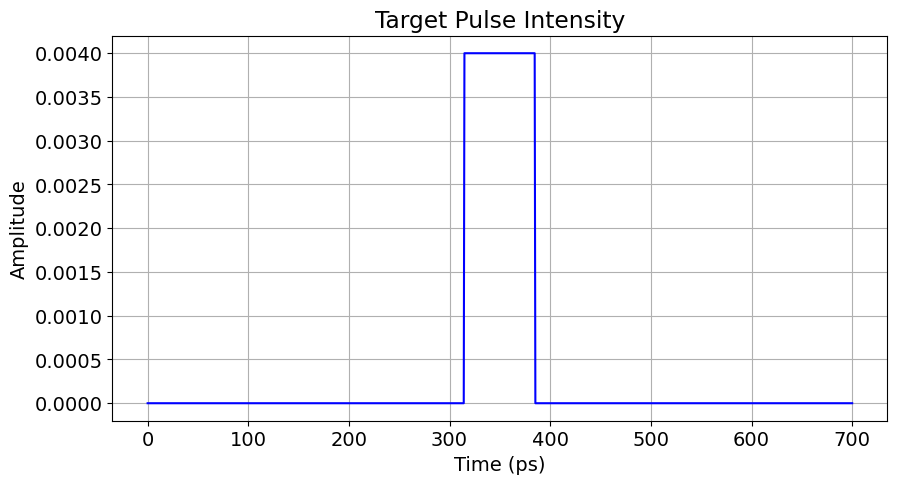

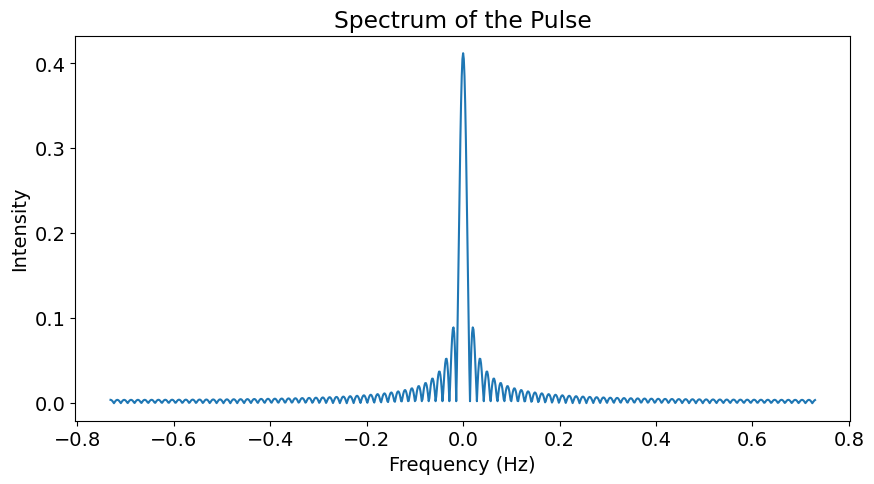

In [5]:
# define parameter of pulse
Amplitude = 0.004
width_percent = 0.1 # size in percent of the window size

# define target pulse
target_intensity = torch.zeros(Nt)
target_intensity[int(Nt/2-Nt*width_percent/2):int(Nt/2+Nt*width_percent/2)] = 1
target_intensity = target_intensity * Amplitude

# define domain of pulse
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(t, target_intensity, color='blue')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Target Pulse Intensity')
plt.grid()
plt.show()


# plot target pulse spectrum
# make copy for plotting
target_intensity_copy = target_intensity.clone().detach()
plot_spectrum(target_intensity_copy, Nt, Lt)

### Define Initial Guess and Mask

In [56]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

# define mask (so that pulse is periodic)
mask = torch.zeros(Nt)
mask[int(Nt/2-Nt*mask_percent/2):int(Nt/2+Nt*mask_percent/2)] = 1

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)

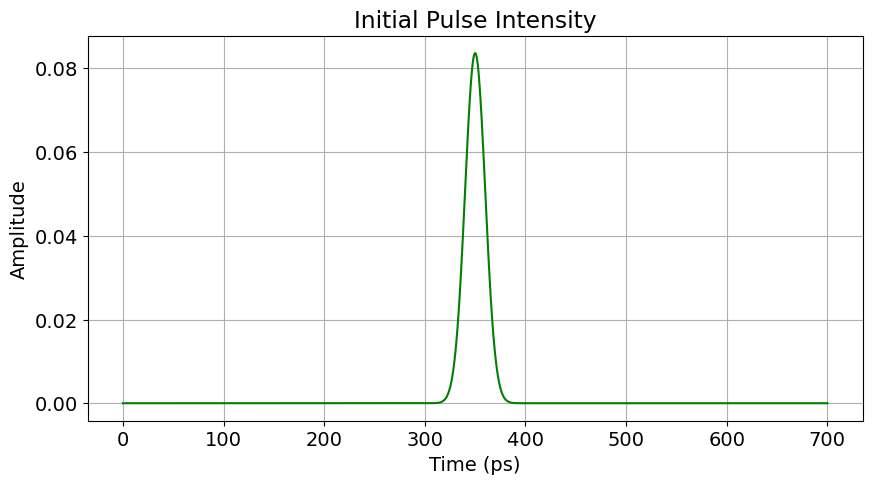

In [57]:
# plot initial pulse
plt.figure(figsize=(10, 5))
plt.plot(t, Ain.detach().numpy(), color='g')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Initial Pulse Intensity')
plt.grid()
plt.show()

### Define Penalty
Anything outside of initial mask gets penalized

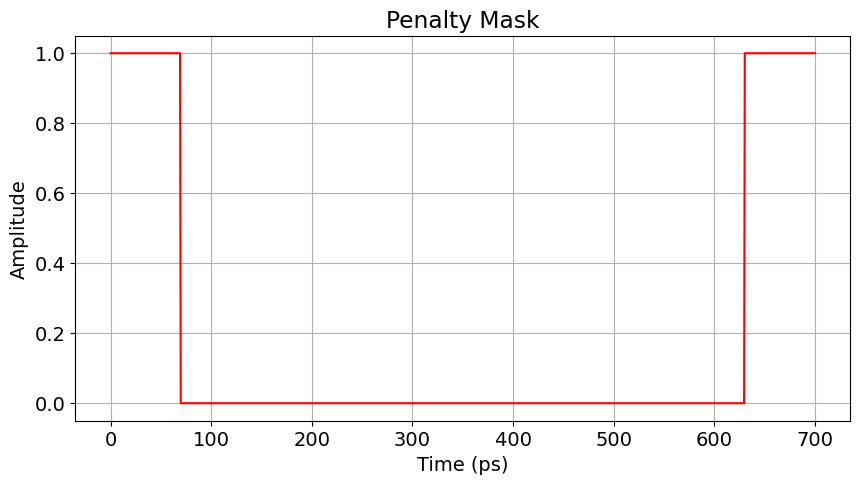

In [58]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [59]:
def forward(Ain):
    Ain = Ain * mask
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(Aev[:,-1])**2, target_intensity)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([Ain], lr=lr)

In [60]:
# # test loss
# Aev = forward(Ain)  # full forward pass
# loss = loss_function(Aev)  # calculate the loss


### Train Model

In [61]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 6.352993295877241e-07
Iteration 50, Loss: 6.733181407980737e-07
Iteration 100, Loss: 5.991099669699906e-07
Iteration 150, Loss: 5.943329028923472e-07
Iteration 200, Loss: 5.890294119126338e-07
Iteration 250, Loss: 5.832344527334499e-07
Iteration 300, Loss: 5.770760367340699e-07
Iteration 350, Loss: 5.706587558051979e-07
Iteration 400, Loss: 5.640668518935854e-07
Iteration 450, Loss: 5.573664338953677e-07
Iteration 500, Loss: 5.506054776560632e-07
Iteration 550, Loss: 5.438131438495475e-07
Iteration 600, Loss: 5.370022222450643e-07
Iteration 650, Loss: 5.301721444084251e-07
Iteration 700, Loss: 5.233083015809825e-07
Iteration 750, Loss: 5.16388467985962e-07
Iteration 800, Loss: 5.093847903481219e-07
Iteration 850, Loss: 5.022659479436697e-07
Iteration 900, Loss: 4.950002221448813e-07
Iteration 950, Loss: 4.875593617725826e-07
Iteration 1000, Loss: 4.799175030711922e-07
Iteration 1050, Loss: 4.7205224973367876e-07
Iteration 1100, Loss: 4.63947003481735e-07
Iteration 11

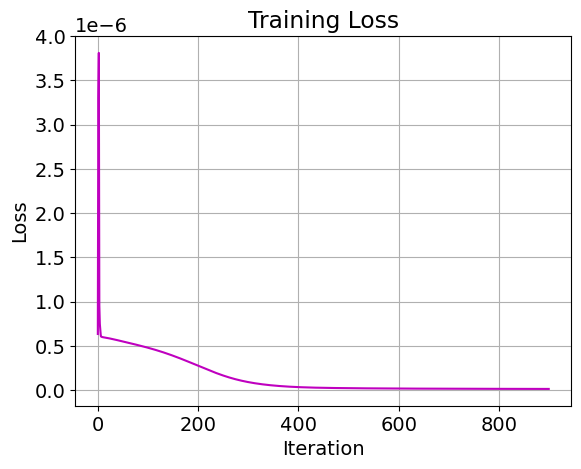

In [62]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

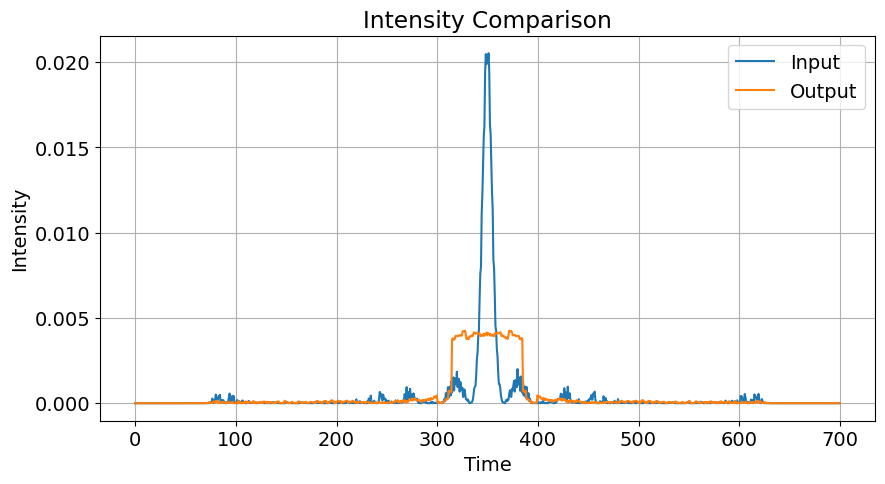

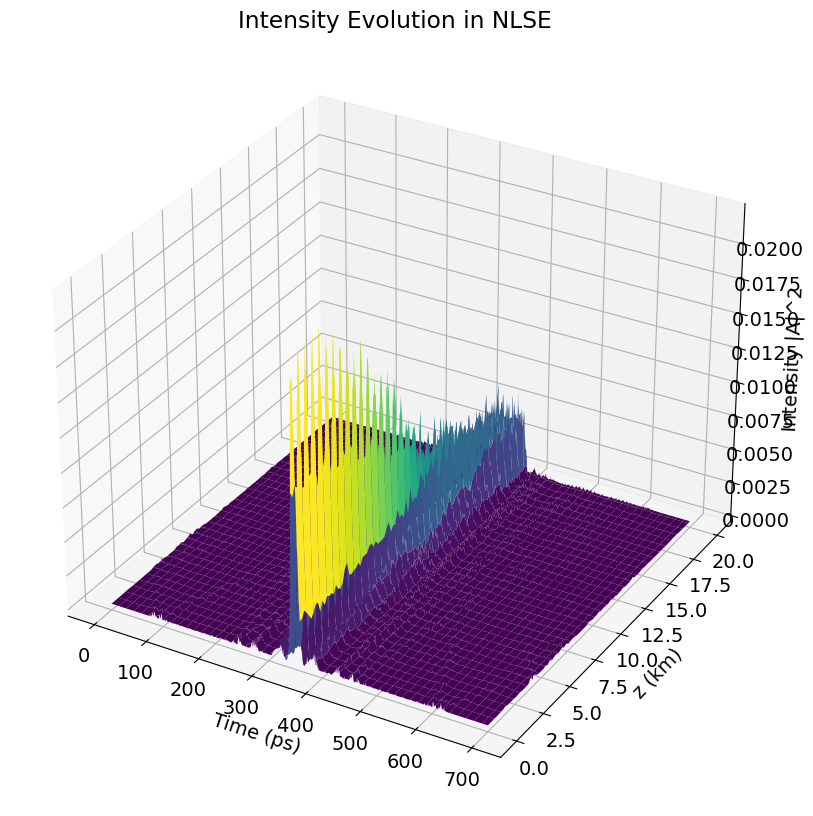

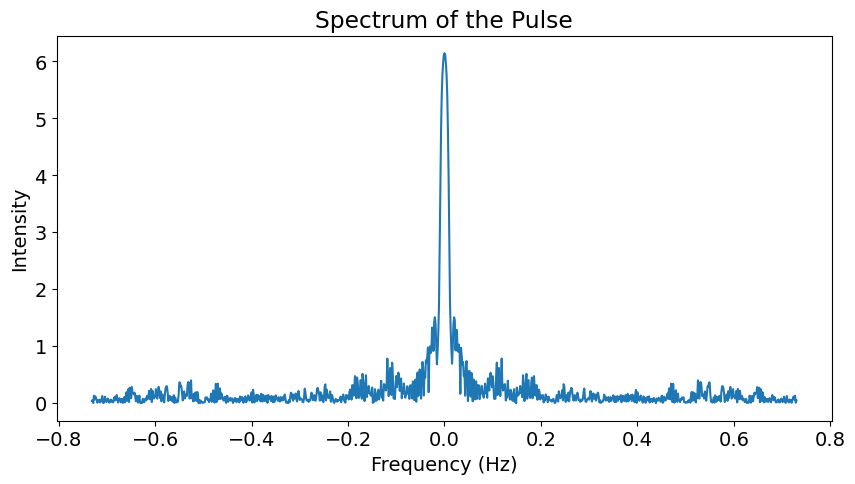

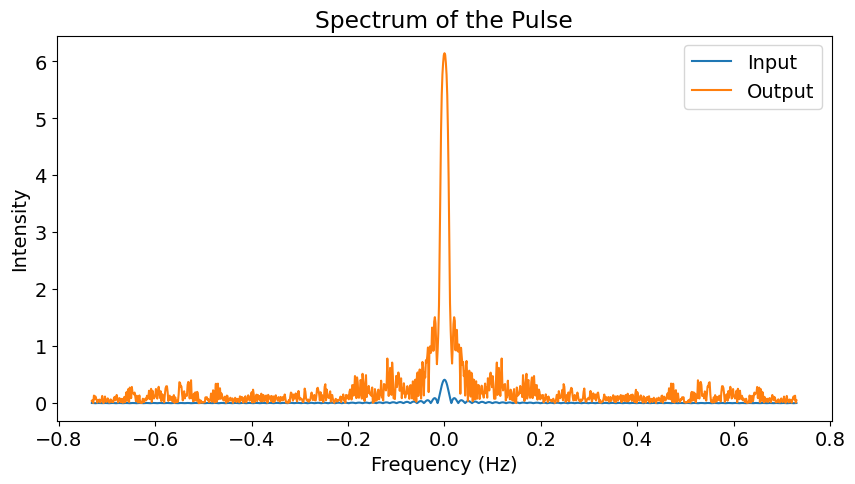

In [63]:
# plot comparison between input and output
Ain_masked = Ain * mask
Aout = Aev[:, -1]

plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectrum
plot_spectrum(Aout, Nt, Lt)

# compare spectrum of target and output
plot_spectrum_comparison(target_intensity, Aout, Nt, Lt)

## Target Pulse 2: Frequency Domain—Gaussian

The Fourier transform essentially breaks down $A(t)$ into a weighted sum of complex exponsentials ($e^{-i 2\pi ft}$) which are equivalent to sine and cosine waves. It returns the (sometimes complex-valued) components/coefficients of the linear combination of these complex exponentials. The absolute value $$|\hat{A}(f)|= \sqrt{\text{Re}(\hat{A}(f))^2 + \text{Im}(\hat{A}(f))^2}$$ of the fourier transform of $A(t)$ (i.e. of the coefficients) tells you the strength of each frequency while the phase $$\phi(f) = \tan^{-1} \left( \frac{\text{Im}(\hat{A}(f))}{\text{Re}(\hat{A}(f))} \right)$$ tells you how "shifted" each frequency component is relative to a reference.

To get an appropriate physical pulse spectrum we will have to find both the real and imaginary parts of the FFT. Here we will try to do it such to match a target absolute value of frequency domain representation $|\hat{A}(f)|$

### Define Parameters

In [21]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size (ps)
Nt = 5000               # Number of temporal points

# define the training parameters
N_train = 7000
lr = 1e-3

w_mse = 1.0
w_pen = 1e10

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)


### Define Target

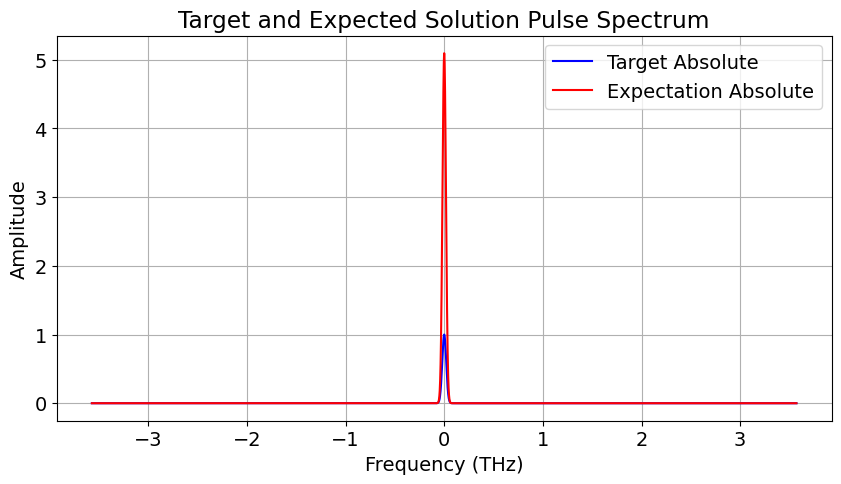

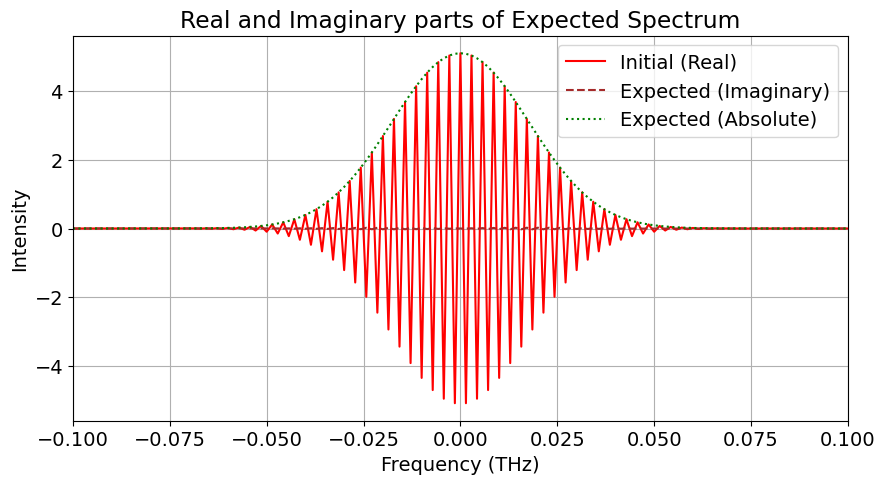

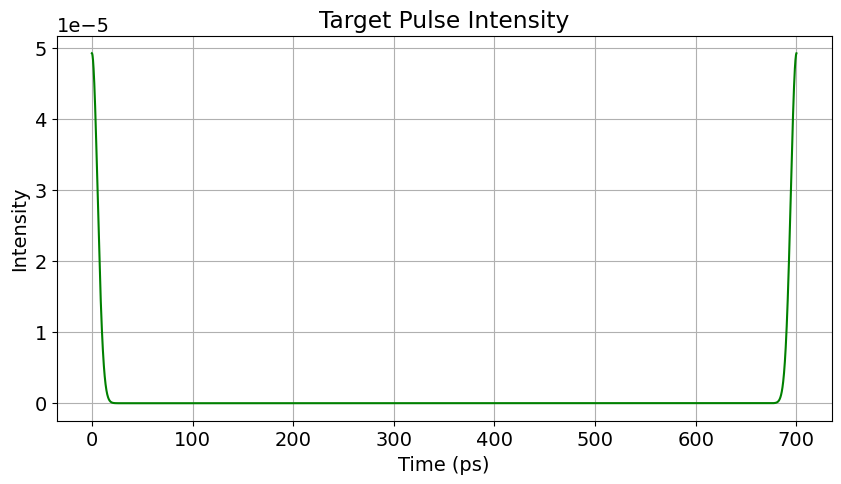

In [22]:
def freq_gaussian_pulse(freqs, center, O0, A0): # this is the absolute value of the target pulse
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(A0)) * torch.exp(-((freqs - center) ** 2) / (2 * O0 ** 2)) # number of frequency bins is the same as the number of time bins

# set Gaussian parameters
center = 0         # Center of the Gaussian pulse
O0 = 0.02           # Width of the Gaussian pulse [THz] (since we measure time in ps, frequency is in THz)
A0 = 1         # sqrt of the peak power of the Gaussian pulse

target = torch.abs(freq_gaussian_pulse(freqs, center, O0, A0))


# get our expectation
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))
expectation = gaussian_pulse(t, Lt/2, 9, 0.001)
gaussian_spectrum = fft(expectation)



# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, target, color='blue', label='Target Absolute')
plt.plot(freqs, torch.abs(gaussian_spectrum), color='red', label='Expectation Absolute')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Target and Expected Solution Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()

# compare real and imaginary parts of target and gausian_spectrum
plt.figure(figsize=(10, 5))
#plt.plot(freqs, target.real, color='blue', label='Target(Real)')
plt.plot(freqs, gaussian_spectrum.real, color='red', label='Initial (Real)')
plt.plot(freqs, gaussian_spectrum.imag, color='brown', linestyle='dashed', label='Expected (Imaginary)')
plt.plot(freqs, torch.abs(gaussian_spectrum), color='green', linestyle='dotted', label='Expected (Absolute)')

plt.xlim(-.1, .1)
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity')
plt.title('Real and Imaginary parts of Expected Spectrum')
plt.grid()
plt.legend()




# ex: show that a given spectrum absolute value does not directly transform to a given physical pulse
pulse = ifft(target)
pulse_int = (torch.abs(pulse)**2).detach().numpy()

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(t, pulse_int, color='green')
plt.xlabel('Time (ps)')
plt.ylabel('Intensity')
plt.title('Target Pulse Intensity')
plt.grid()

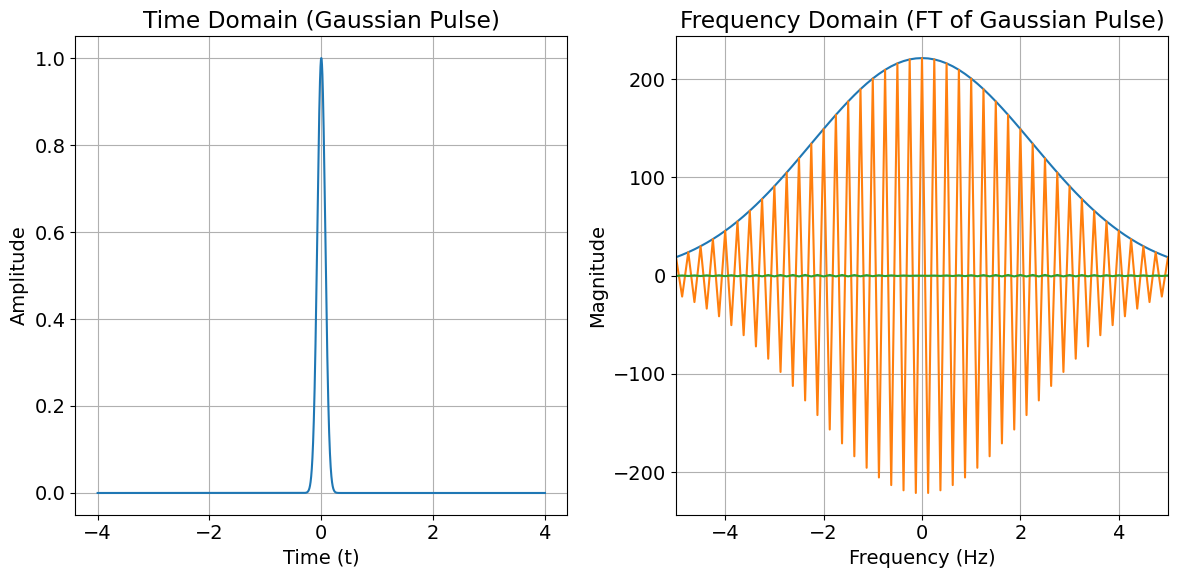

In [19]:
# Parameters
N = 10000  # Number of samples
t = np.linspace(-4, 4, N)  # Time domain samples
f_t = np.exp(-(t/0.1)**2)  # Gaussian pulse in the time domain

# Fourier Transform of the Gaussian pulse
fft_result = np.fft.fftshift(np.fft.fft(f_t))  # Shift the zero frequency component to the center
frequencies = np.fft.fftshift(np.fft.fftfreq(N, d=(t[1] - t[0])))

# Plot the Gaussian pulse in the time domain
plt.figure(figsize=(12, 6))

# Plot time domain
plt.subplot(1, 2, 1)
plt.plot(t, f_t, label='Gaussian Pulse')
plt.xlabel('Time (t)')
plt.ylabel('Amplitude')
plt.title('Time Domain (Gaussian Pulse)')
plt.grid(True)

# Plot Fourier Transform (Frequency domain)
plt.subplot(1, 2, 2)
plt.plot(frequencies, np.abs(fft_result), label='FT of Gaussian Pulse')
# plot real and immaginary part
plt.plot(frequencies, np.real(fft_result), label='Real')
plt.plot(frequencies, np.imag(fft_result), label='Imaginary')
plt.xlim(-5, 5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Domain (FT of Gaussian Pulse)')
plt.grid(True)

plt.tight_layout()
plt.show()


### Define Initial Guess and Mask
Initial Guess is also Gaussian but a different one (as a first try)

In [110]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

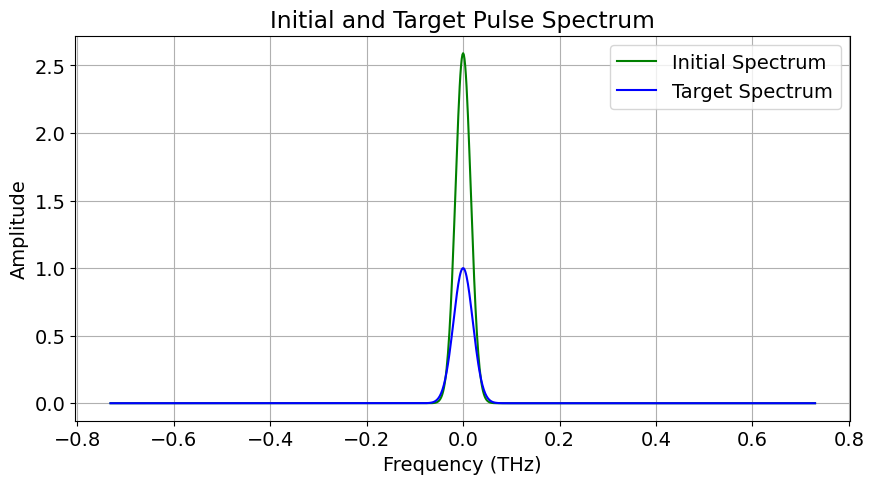

In [111]:
# plot initial pulse spectrum vs target spectrum
Ain_spectrum = fft(Ain)
# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(Ain_spectrum).detach().numpy(), color='green', label='Initial Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Initial and Target Pulse Spectrum')
plt.grid()
plt.legend()

### Define Penalty
Anything outside of initial mask gets penalized

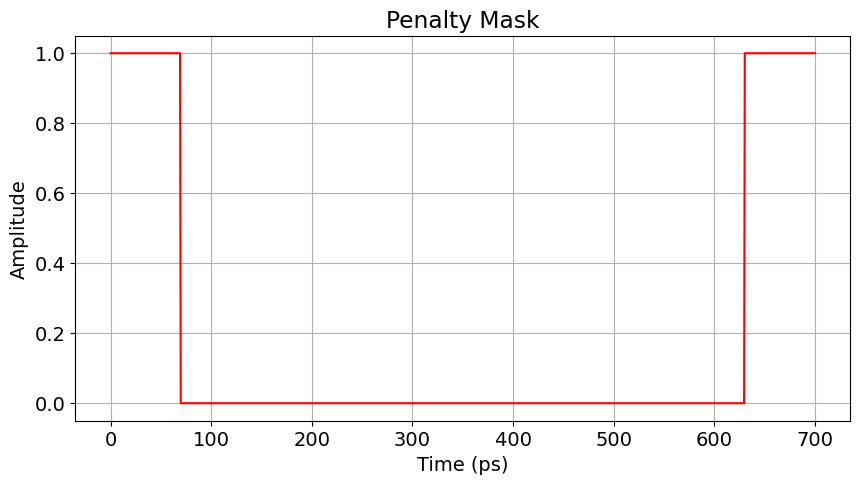

In [112]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [113]:
def forward(Ain):
    Ain = Ain
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(fft(Aev[:,-1])), target)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([Ain], lr=lr)

In [114]:
# # test loss
# Aev = forward(Ain)  # full forward pass
# loss = loss_function(Aev)  # calculate the loss


### Train Model

In [115]:
losses = []

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.04924709349870682
Iteration 50, Loss: 0.04726479575037956
Iteration 100, Loss: 0.04273012652993202
Iteration 150, Loss: 0.0404389388859272
Iteration 200, Loss: 0.03790048882365227
Iteration 250, Loss: 0.03522047400474548
Iteration 300, Loss: 0.032485440373420715
Iteration 350, Loss: 0.02976229600608349
Iteration 400, Loss: 0.027102142572402954
Iteration 450, Loss: 0.024542588740587234
Iteration 500, Loss: 0.022110816091299057
Iteration 550, Loss: 0.019825106486678123
Iteration 600, Loss: 0.01769632287323475
Iteration 650, Loss: 0.015729544684290886
Iteration 700, Loss: 0.013925342820584774
Iteration 750, Loss: 0.012280704453587532
Iteration 800, Loss: 0.010790093801915646
Iteration 850, Loss: 0.0094461003318429
Iteration 900, Loss: 0.008240040391683578
Iteration 950, Loss: 0.007162516470998526
Iteration 1000, Loss: 0.006204025354236364
Iteration 1050, Loss: 0.005354954395443201
Iteration 1100, Loss: 0.004605860449373722
Iteration 1150, Loss: 0.00394758814945817
Ite

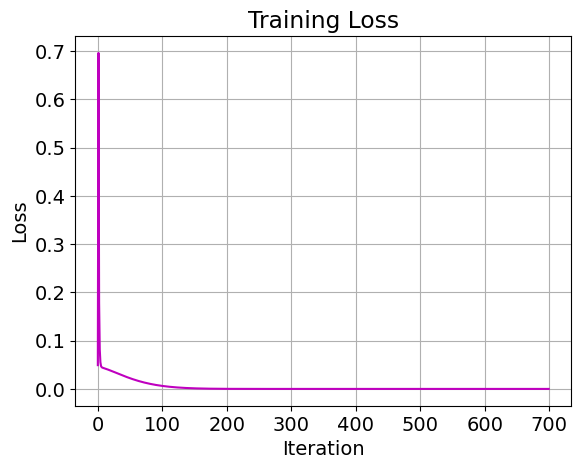

In [116]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

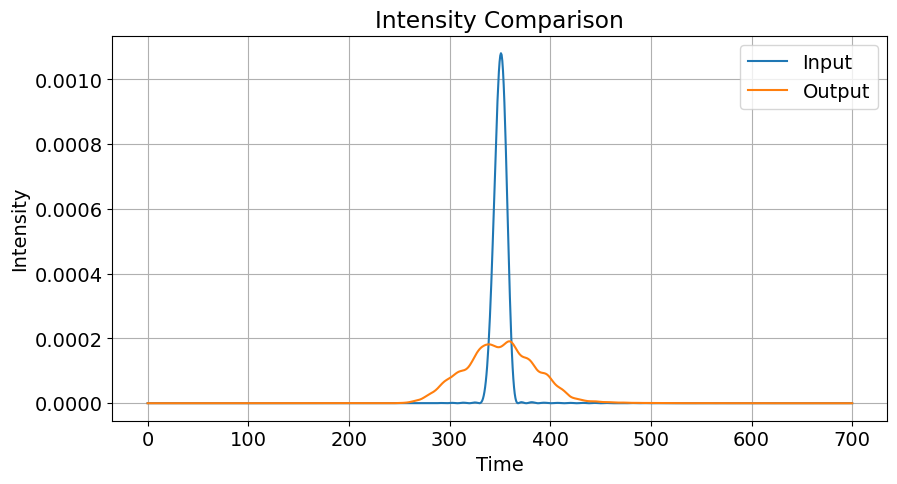

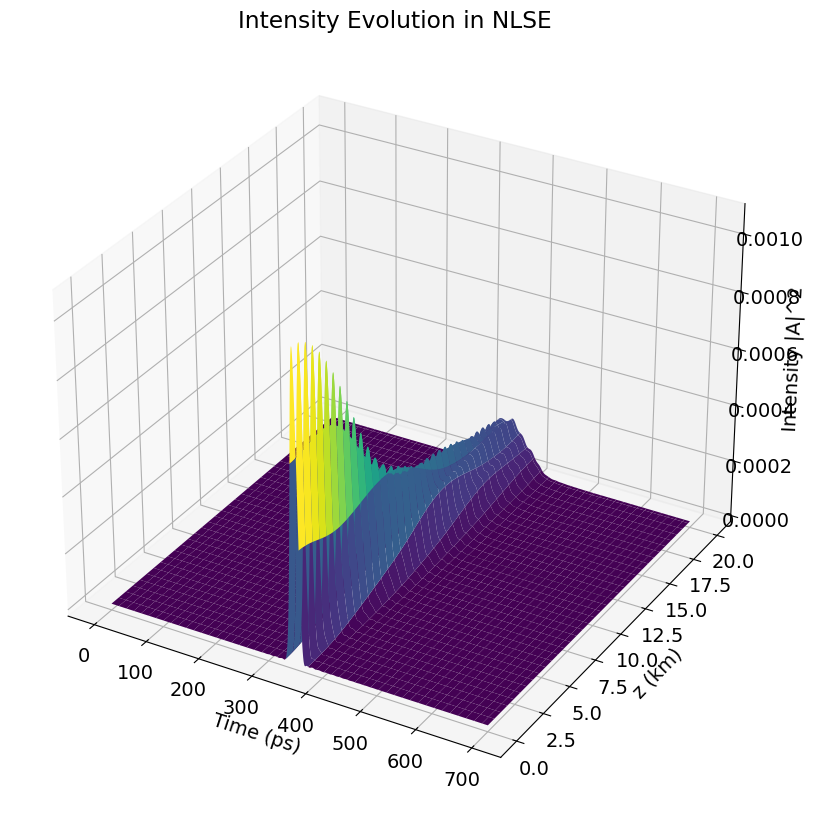

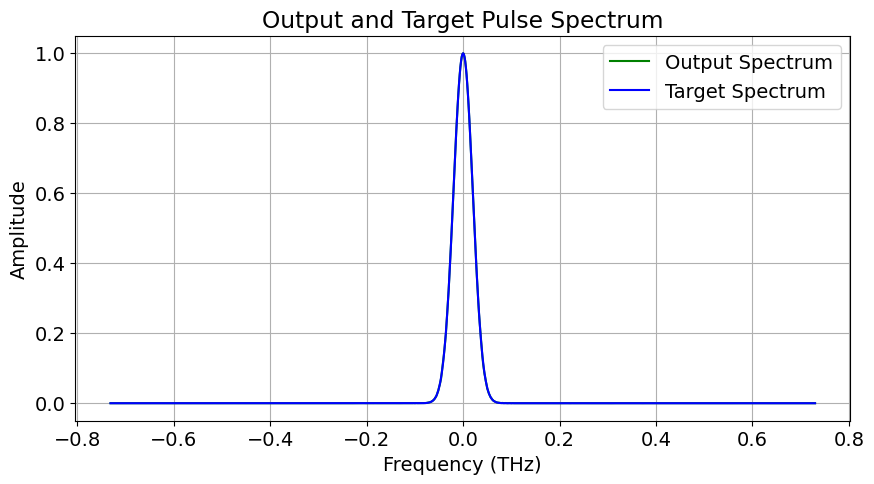

In [117]:
# plot comparison between input and output
Ain_masked = Ain
Aout = Aev[:,-1]
plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectra
Aout_spectrum = torch.abs(fft(Aout))
plt.figure(figsize=(10, 5))
plt.plot(freqs, Aout_spectrum.detach().numpy(), color='green', label='Output Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Output and Target Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()

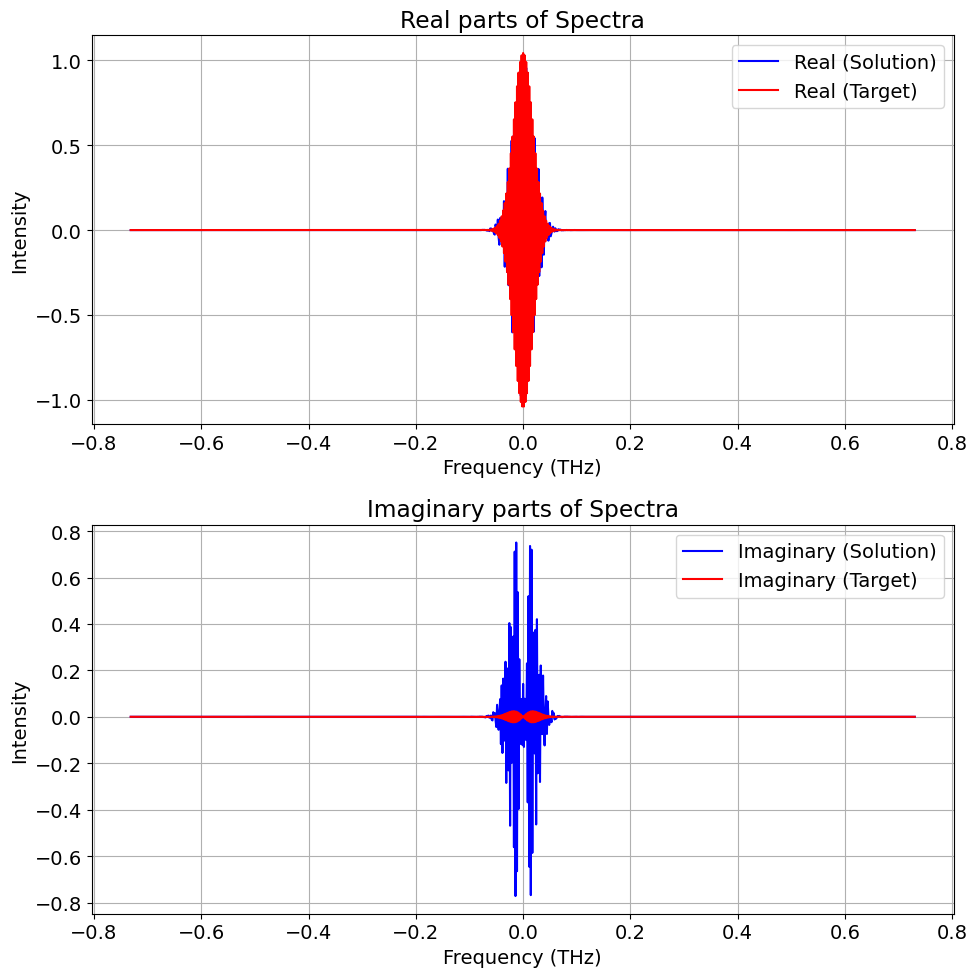

In [118]:
# define function to compare real and imaginary parts of two spectra (on two subplots for better visibility)
def plot_spectrum_comparison(A, B, freqs):
    As = fft(A).detach().numpy()
    Bs = fft(B).detach().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, As.real, color='blue', label='Real (Solution)')
    plt.plot(freqs, Bs.real, color='red', label='Real (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Real parts of Spectra')
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs, As.imag, color='blue', label='Imaginary (Solution)')
    plt.plot(freqs, Bs.imag, color='red', label='Imaginary (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Imaginary parts of Spectra')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
# plot comparison between real and imaginary parts of target and output spectra
plot_spectrum_comparison(Aout, expectation, freqs)

## Target Pulse 2: Frequency Domain—Gaussian Wave (Optimized)

Instead of having waveform in time domain as input use as the input the real and imaginary parts of the input waveform fourier transform (in hoped that this would give more direct access to the toggles we want the model to turn while also keeping somewat smooth and physical solutions).

### Define Parameters

In [ ]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 5000
lr = 1e-3

w_mse = 1.0
w_pen = 1e10

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)


### Define Target

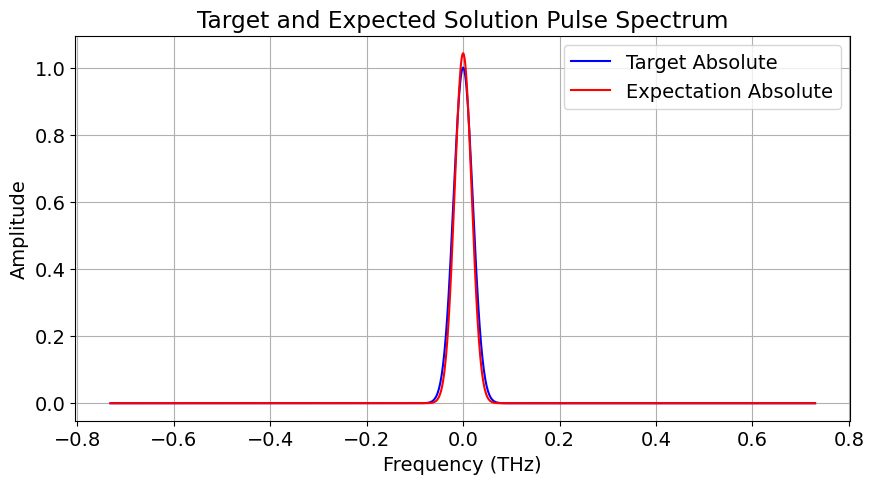

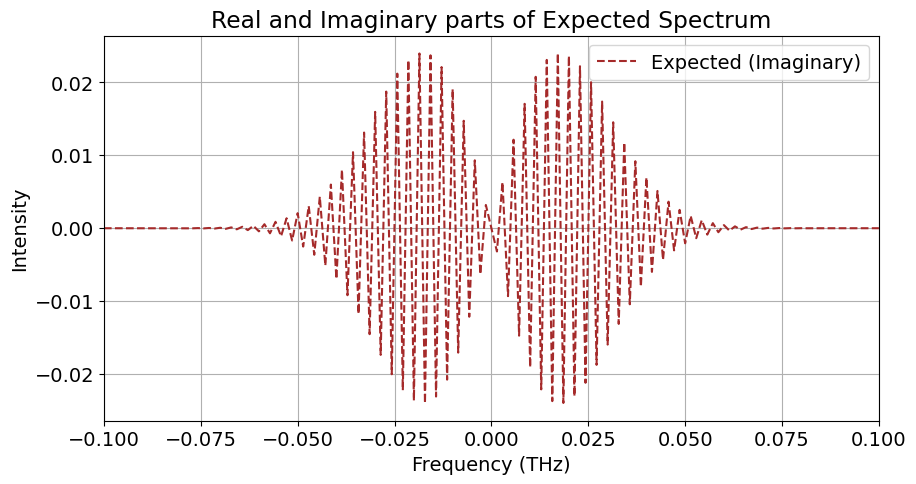

In [ ]:
def freq_gaussian_pulse(freqs, center, O0, A0): # this is the absolute value of the target pulse
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(A0)) * torch.exp(-((freqs - center) ** 2) / (2 * O0 ** 2)) # number of frequency bins is the same as the number of time bins

# set Gaussian parameters
center = 0         # Center of the Gaussian pulse
O0 = 0.02           # Width of the Gaussian pulse [THz] (since we measure time in ps, frequency is in THz)
A0 = 1         # sqrt of the peak power of the Gaussian pulse

target = torch.abs(freq_gaussian_pulse(freqs, center, O0, A0))


# get our expectation
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))
expectation = gaussian_pulse(t, Lt/2, 9, 0.001)
gaussian_spectrum = fft(expectation)

### Define Initial Guess and Mask
Initial Guess is the real and imaginary parts of a Gaussian FFT.

In [ ]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = gaussian_pulse(t, center, T0, P0)
Ain_spectrum = fft(Ain)
r = Ain_spectrum.real
i = Ain_spectrum.imag

real = torch.nn.Parameter(r.clone().detach().requires_grad_(True))
imag = torch.nn.Parameter(i.clone().detach().requires_grad_(True))

### Define Useful Functions

In [ ]:
def reconstructA(real, imag):
    return ifft(real + 1j * imag)

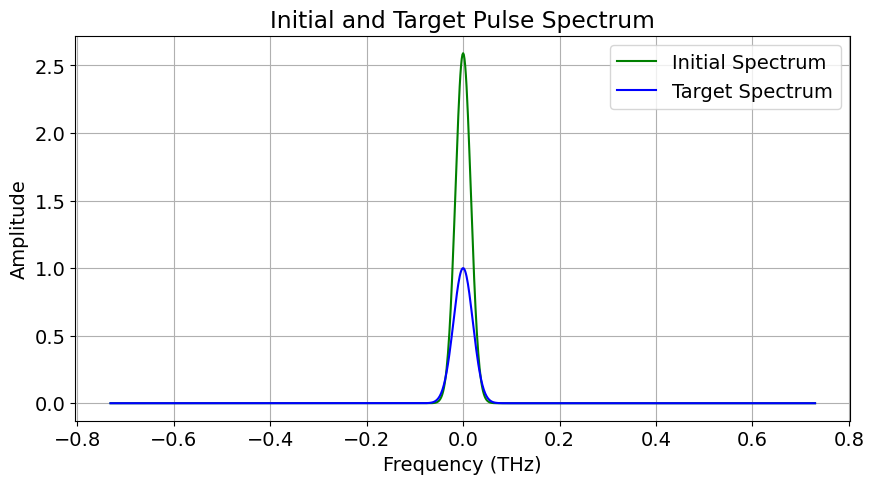

In [ ]:
# plot initial pulse spectrum vs target spectrum
Ain_spectrum = fft(Ain)
# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(Ain_spectrum).detach().numpy(), color='green', label='Initial Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Initial and Target Pulse Spectrum')
plt.grid()
plt.legend()

### Define Penalty
Anything outside of initial mask gets penalized

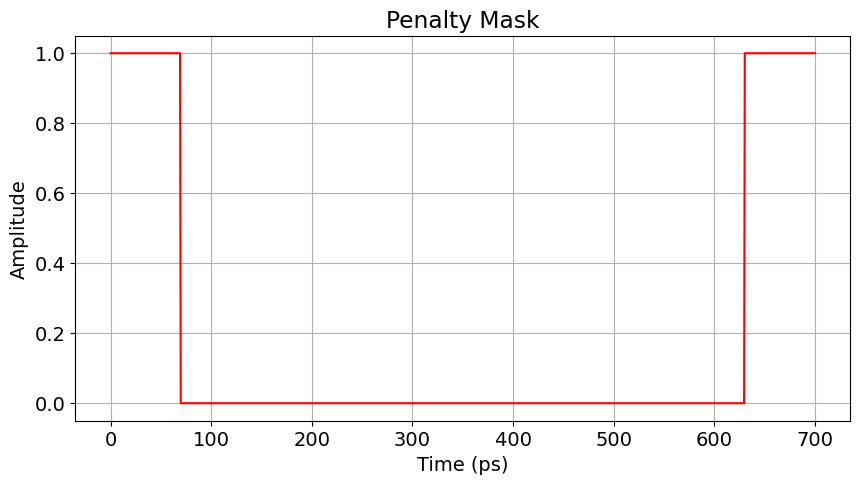

In [ ]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [ ]:
def forward(real, imag):
    Ain = reconstructA(real, imag)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(fft(Aev[:,-1])), target)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([real, imag], lr=lr)

### Train Model

In [ ]:
losses = []

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(real, imag)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.04924708232283592
Iteration 50, Loss: 0.04606655612587929
Iteration 100, Loss: 0.04274115711450577
Iteration 150, Loss: 0.03950029984116554
Iteration 200, Loss: 0.036422427743673325
Iteration 250, Loss: 0.033530719578266144
Iteration 300, Loss: 0.030829209834337234
Iteration 350, Loss: 0.028312956914305687
Iteration 400, Loss: 0.025973742827773094
Iteration 450, Loss: 0.0238020196557045
Iteration 500, Loss: 0.021788066253066063
Iteration 550, Loss: 0.01992202363908291
Iteration 600, Loss: 0.0181947760283947
Iteration 650, Loss: 0.016597498208284378
Iteration 700, Loss: 0.015121882781386375
Iteration 750, Loss: 0.013759932480752468
Iteration 800, Loss: 0.012504233978688717
Iteration 850, Loss: 0.011347789317369461
Iteration 900, Loss: 0.010283930227160454
Iteration 950, Loss: 0.009306338615715504
Iteration 1000, Loss: 0.008409137837588787
Iteration 1050, Loss: 0.007586699910461903
Iteration 1100, Loss: 0.0068337335251271725
Iteration 1150, Loss: 0.006145333871245384

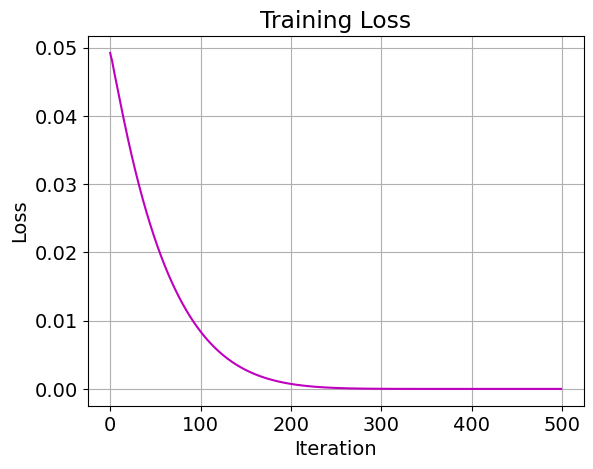

In [ ]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

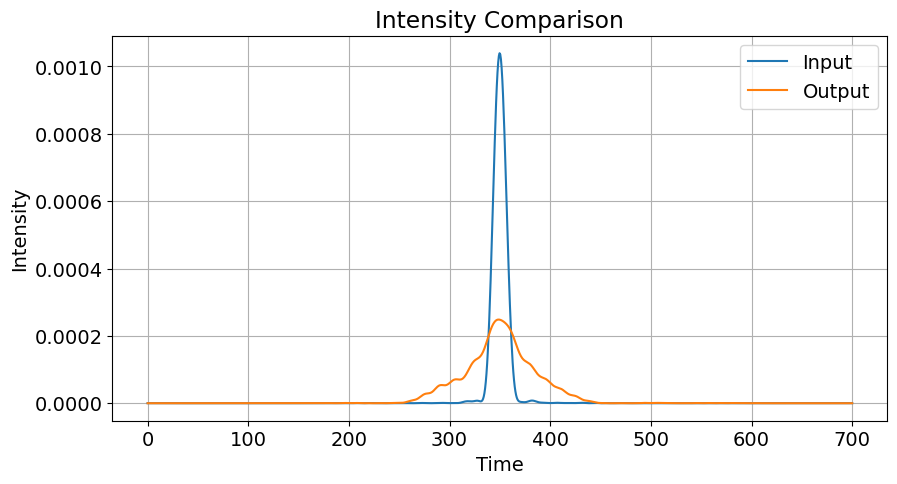

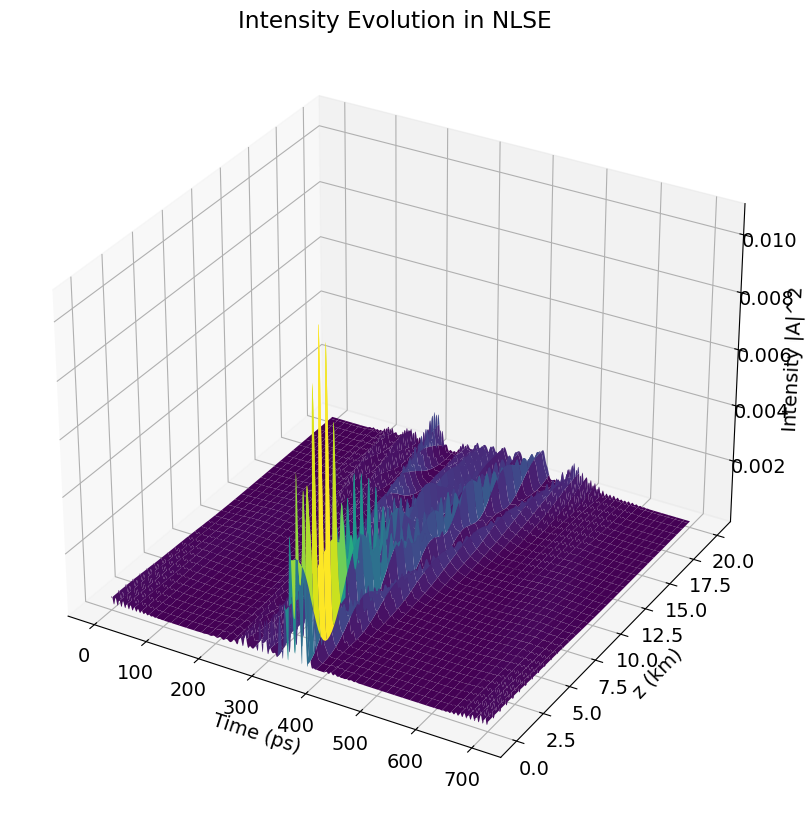

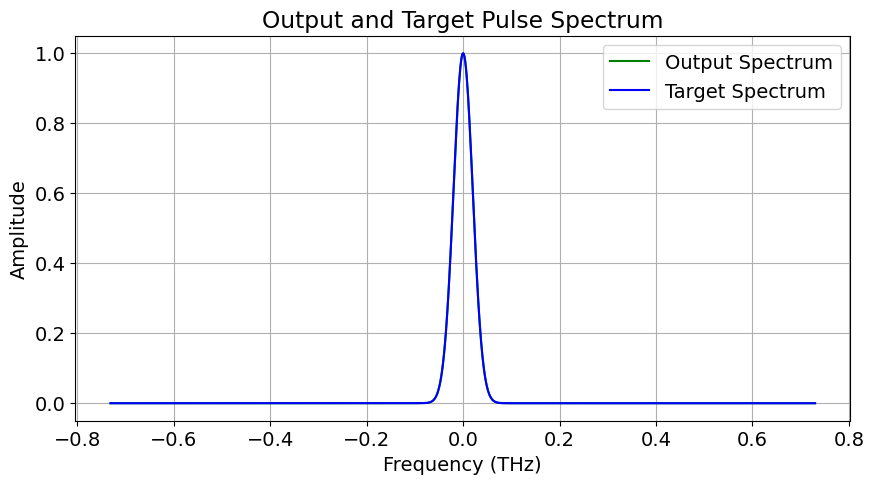

In [ ]:
# plot comparison between input and output
Ain = reconstructA(real, imag)
Aout = Aev[:,-1]
plot_intensity_comparison(Ain, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectra
Aout_spectrum = torch.abs(fft(Aout))
plt.figure(figsize=(10, 5))
plt.plot(freqs, Aout_spectrum.detach().numpy(), color='green', label='Output Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Output and Target Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()

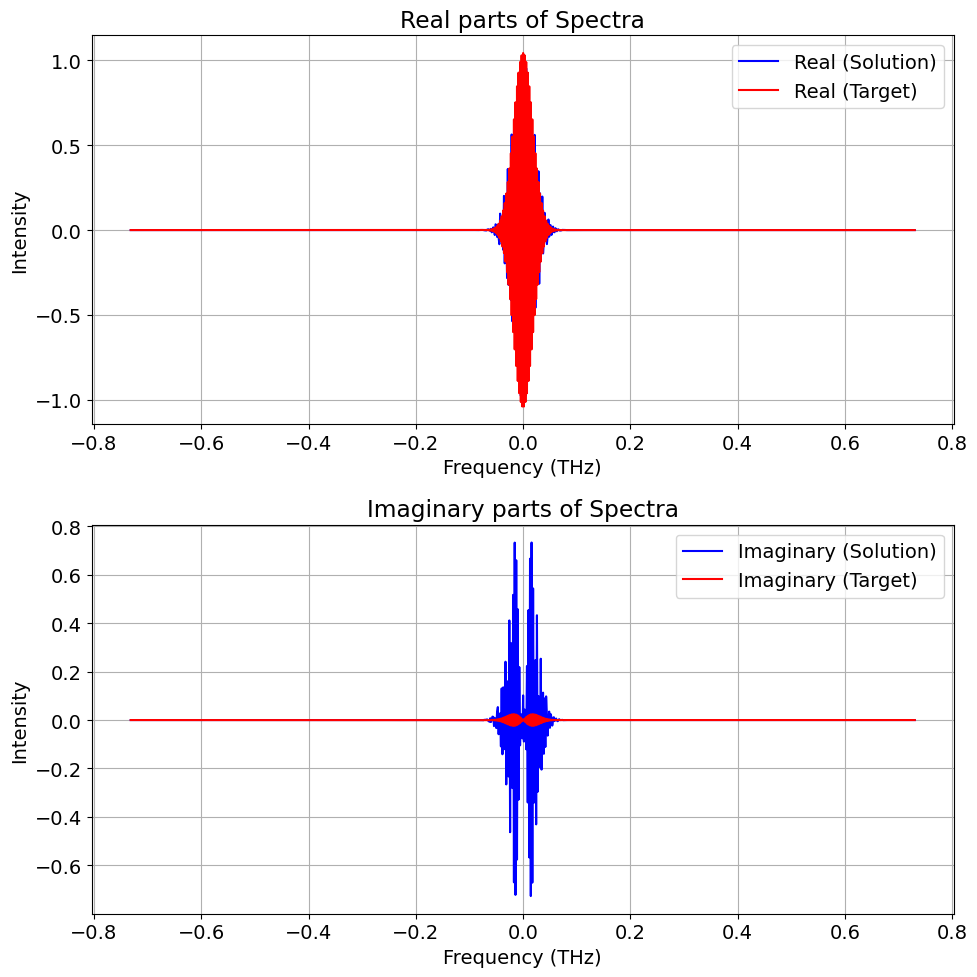

In [ ]:
# define function to compare real and imaginary parts of two spectra (on two subplots for better visibility)
def plot_spectrum_comparison(A, B, freqs):
    As = fft(A).detach().numpy()
    Bs = fft(B).detach().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, As.real, color='blue', label='Real (Solution)')
    plt.plot(freqs, Bs.real, color='red', label='Real (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Real parts of Spectra')
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs, As.imag, color='blue', label='Imaginary (Solution)')
    plt.plot(freqs, Bs.imag, color='red', label='Imaginary (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Imaginary parts of Spectra')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
# plot comparison between real and imaginary parts of target and output spectra
plot_spectrum_comparison(Aout, expectation, freqs)

## Target Pulse 3: Frequency Domain—Square

The Fourier transform essentially breaks down $A(t)$ into a weighted sum of complex exponsentials ($e^{-i 2\pi ft}$) which are equivalent to sine and cosine waves. It returns the (sometimes complex-valued) components/coefficients of the linear combination of these complex exponentials. The absolute value $$|\hat{A}(f)|= \sqrt{\text{Re}(\hat{A}(f))^2 + \text{Im}(\hat{A}(f))^2}$$ of the fourier transform of $A(t)$ (i.e. of the coefficients) tells you the strength of each frequency while the phase $$\phi(f) = \tan^{-1} \left( \frac{\text{Im}(\hat{A}(f))}{\text{Re}(\hat{A}(f))} \right)$$ tells you how "shifted" each frequency component is relative to a reference.

To get an appropriate physical pulse spectrum we will have to find both the real and imaginary parts of the FFT. Here we will try to do it such to match a target absolute value of frequency domain representation $|\hat{A}(f)|$

### Define Parameters

In [120]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 7000
lr = 1e-3

w_mse = 1.0
w_pen = 1e10

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)


### Define Target

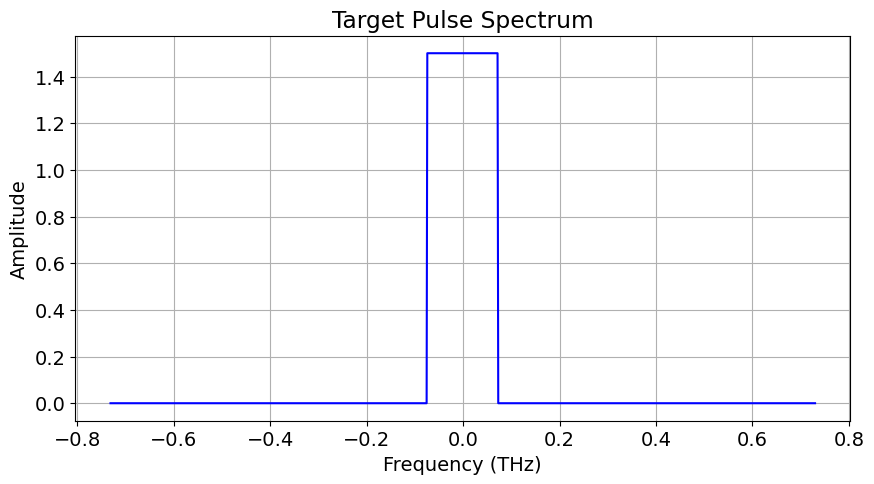

In [129]:
# define parameter of pulse
Amplitude = 1.5
width_percent = 0.1 # size in percent of the window size (frequency domain)

# define target pulse
target = torch.zeros(Nt)
target[int(Nt/2-Nt*width_percent/2):int(Nt/2+Nt*width_percent/2)] = 1
target = target * Amplitude

freqs = get_freqs(Nt, Lt) # get frequencies for plotting

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, target, color='blue')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Target Pulse Spectrum')
plt.grid()
plt.show()

# # ex: show that a given spectrum absolute value does not directly transform to a given physical pulse
# pulse = ifft(target)
# pulse_int = (torch.abs(pulse)**2).detach().numpy()

# # plot target pulse
# plt.figure(figsize=(10, 5))
# plt.plot(t, pulse_int, color='green')
# plt.xlabel('Time (ps)')
# plt.ylabel('Intensity')
# plt.title('Target Pulse Intensity')
# plt.grid()

### Define Initial Guess and Mask
Initial Guess is also Gaussian but a different one (as a first try)

In [130]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

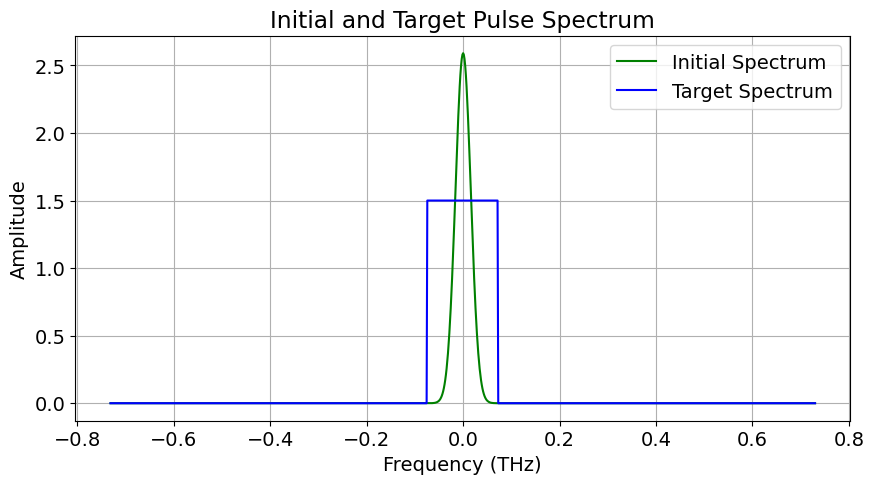

In [131]:
# plot initial pulse spectrum vs target spectrum
Ain_spectrum = fft(Ain)
# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(Ain_spectrum).detach().numpy(), color='green', label='Initial Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Initial and Target Pulse Spectrum')
plt.grid()
plt.legend()

### Define Penalty
Anything outside of initial mask gets penalized

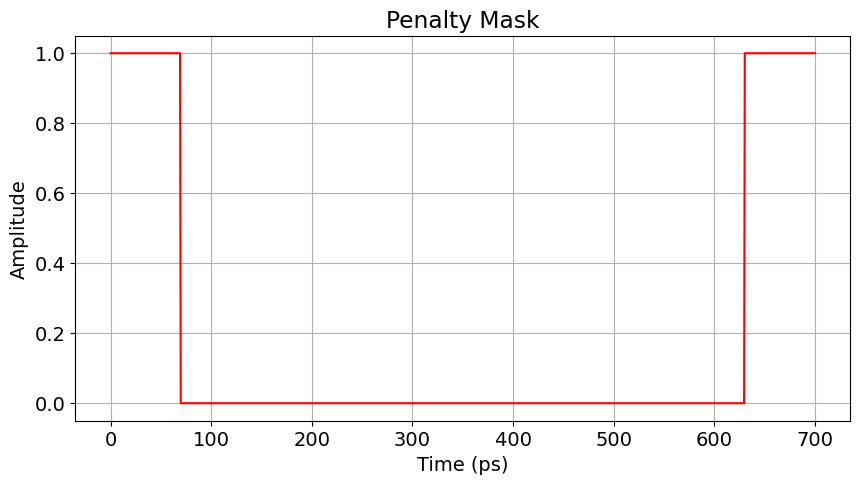

In [132]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [133]:
def forward(Ain):
    Ain = Ain
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(fft(Aev[:,-1])), target)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([Ain], lr=lr)

In [134]:
# # test loss
# Aev = forward(Ain)  # full forward pass
# loss = loss_function(Aev)  # calculate the loss


### Train Model

In [135]:
losses = []

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.17279841005802155
Iteration 50, Loss: 0.16028031706809998
Iteration 100, Loss: 0.15198077261447906
Iteration 150, Loss: 0.1447656899690628
Iteration 200, Loss: 0.13664589822292328
Iteration 250, Loss: 0.12794548273086548
Iteration 300, Loss: 0.11894776672124863
Iteration 350, Loss: 0.10987956076860428
Iteration 400, Loss: 0.1009204164147377
Iteration 450, Loss: 0.09220998734235764
Iteration 500, Loss: 0.08385387808084488
Iteration 550, Loss: 0.07592862844467163
Iteration 600, Loss: 0.068486787378788
Iteration 650, Loss: 0.06156054511666298
Iteration 700, Loss: 0.05516548454761505
Iteration 750, Loss: 0.049303822219371796
Iteration 800, Loss: 0.043967194855213165
Iteration 850, Loss: 0.03913921117782593
Iteration 900, Loss: 0.034797389060258865
Iteration 950, Loss: 0.030914941802620888
Iteration 1000, Loss: 0.027462130412459373
Iteration 1050, Loss: 0.02440759167075157
Iteration 1100, Loss: 0.021719161421060562
Iteration 1150, Loss: 0.019364742562174797
Iteration 12

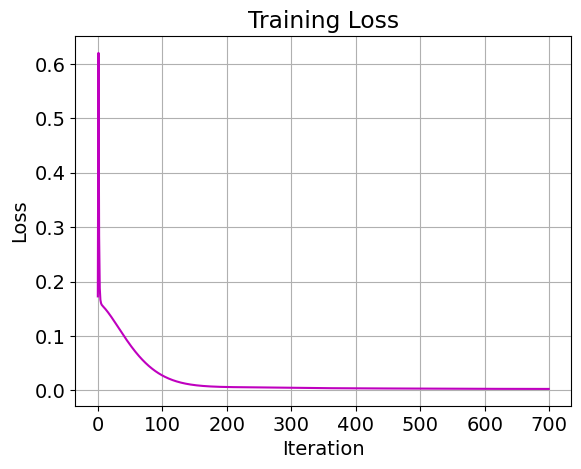

In [136]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

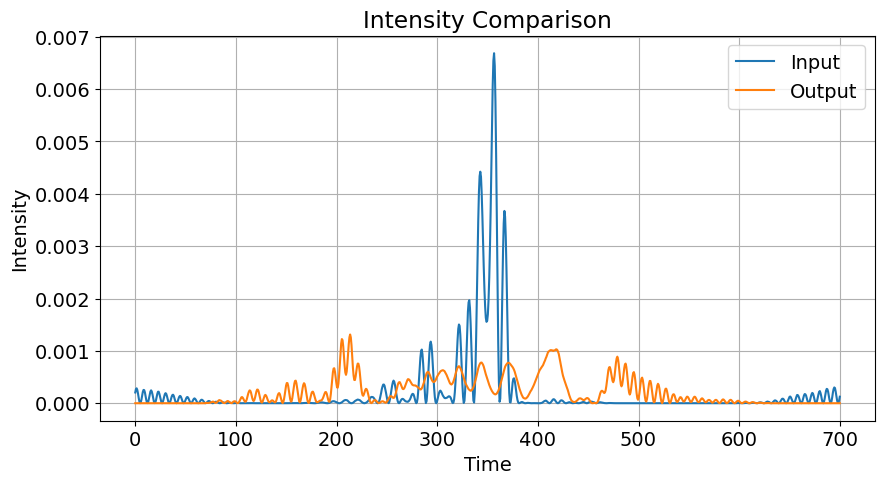

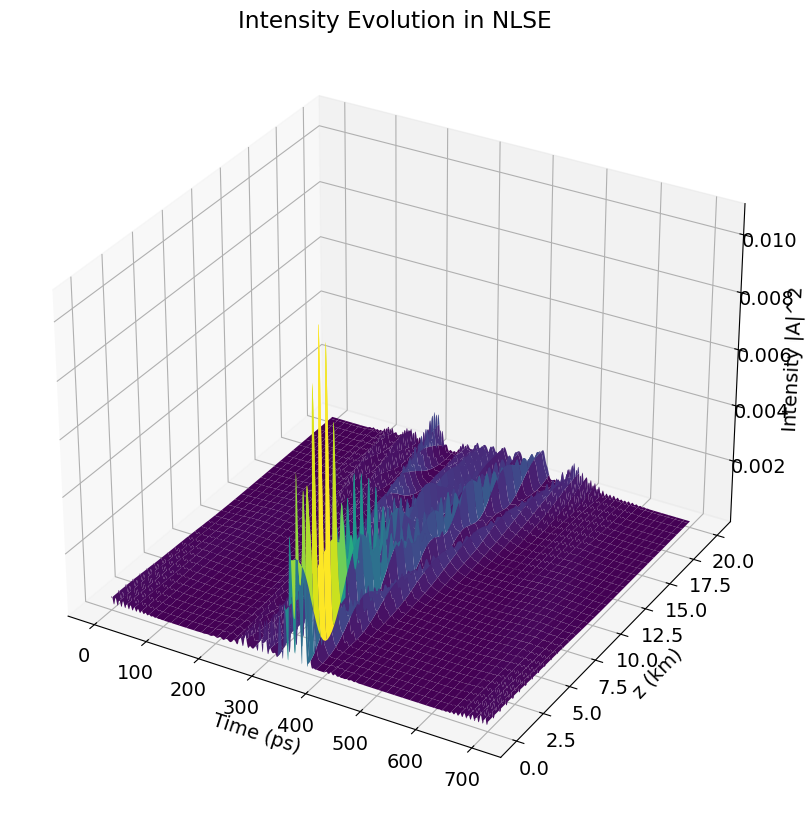

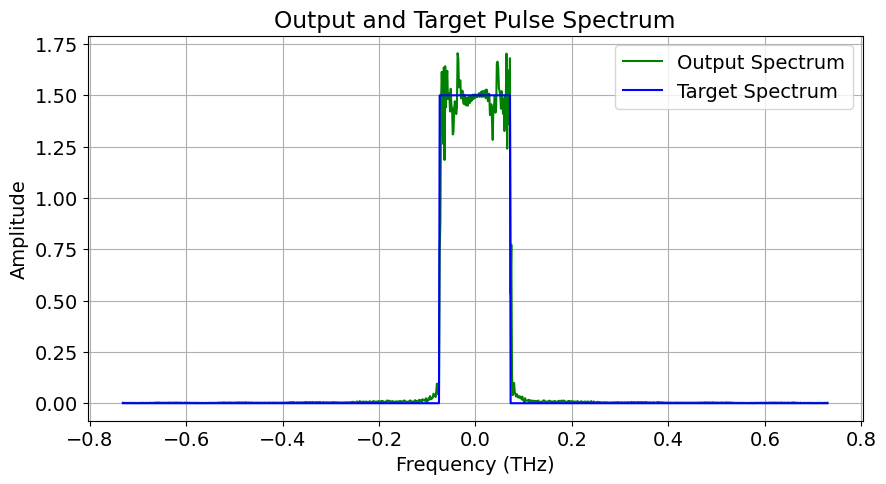

In [137]:
# plot comparison between input and output
Ain_masked = Ain
Aout = Aev[:,-1]
plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectra
Aout_spectrum = torch.abs(fft(Aout))
plt.figure(figsize=(10, 5))
plt.plot(freqs, Aout_spectrum.detach().numpy(), color='green', label='Output Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Output and Target Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()

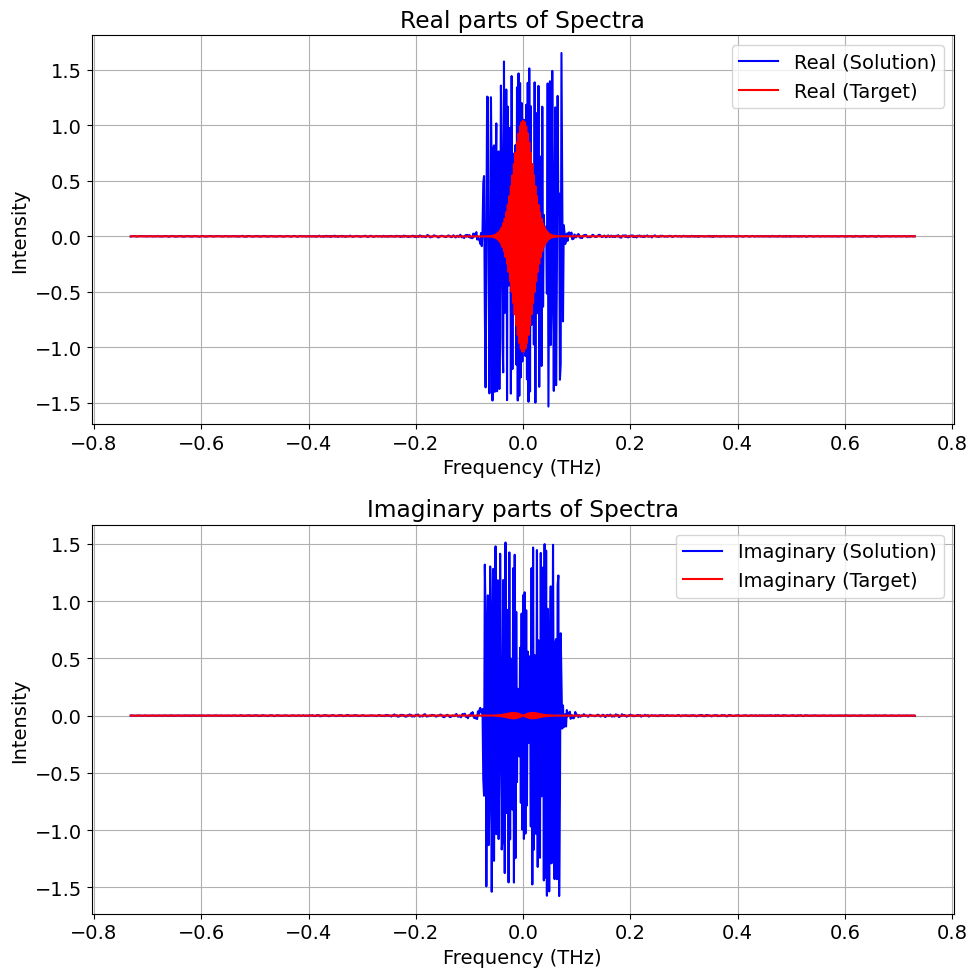

In [138]:
# define function to compare real and imaginary parts of two spectra (on two subplots for better visibility)
def plot_spectrum_comparison(A, B, freqs):
    As = fft(A).detach().numpy()
    Bs = fft(B).detach().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, As.real, color='blue', label='Real (Solution)')
    plt.plot(freqs, Bs.real, color='red', label='Real (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Real parts of Spectra')
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs, As.imag, color='blue', label='Imaginary (Solution)')
    plt.plot(freqs, Bs.imag, color='red', label='Imaginary (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Imaginary parts of Spectra')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
# plot comparison between real and imaginary parts of target and output spectra
plot_spectrum_comparison(Aout, expectation, freqs)

## Target Pulse 3: Frequency Domain—Square Wave (Optimized)

Instead of having waveform in time domain as input use as the input the real and imaginary parts of the input waveform fourier transform (in hoped that this would give more direct access to the toggles we want the model to turn while also keeping somewat smooth and physical solutions).

### Define Parameters

In [195]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 5000
lr = 1e-3

w_mse = 1.0
w_pen = 1e10

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)


### Define Target

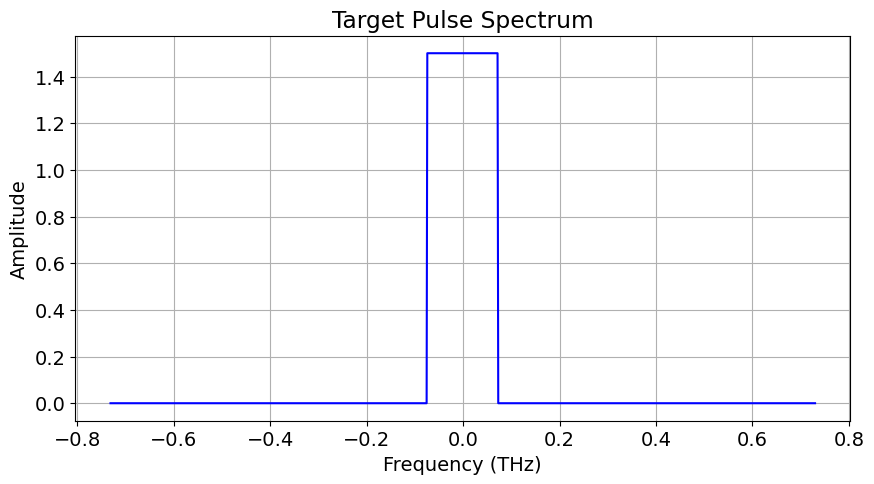

In [197]:
# define parameter of pulse
Amplitude = 1.5
width_percent = 0.1 # size in percent of the window size (frequency domain)

# define target pulse
target = torch.zeros(Nt)
target[int(Nt/2-Nt*width_percent/2):int(Nt/2+Nt*width_percent/2)] = 1
target = target * Amplitude

freqs = get_freqs(Nt, Lt) # get frequencies for plotting

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, target, color='blue')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Target Pulse Spectrum')
plt.grid()
plt.show()


### Define Initial Guess and Mask
Initial Guess is the real and imaginary parts of a Gaussian FFT.

In [198]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = gaussian_pulse(t, center, T0, P0)
Ain_spectrum = fft(Ain)
r = Ain_spectrum.real
i = Ain_spectrum.imag

real = torch.nn.Parameter(r.clone().detach().requires_grad_(True))
imag = torch.nn.Parameter(i.clone().detach().requires_grad_(True))

### Define Useful Functions

In [199]:
def reconstructA(real, imag):
    return ifft(real + 1j * imag)

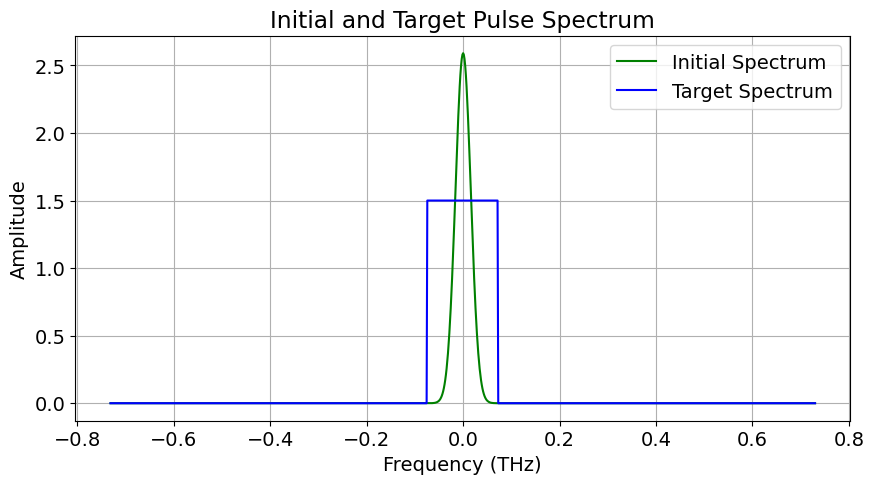

In [200]:
# plot initial pulse spectrum vs target spectrum
Ain_spectrum = fft(Ain)
# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(Ain_spectrum).detach().numpy(), color='green', label='Initial Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Initial and Target Pulse Spectrum')
plt.grid()
plt.legend()

### Define Penalty
Anything outside of initial mask gets penalized

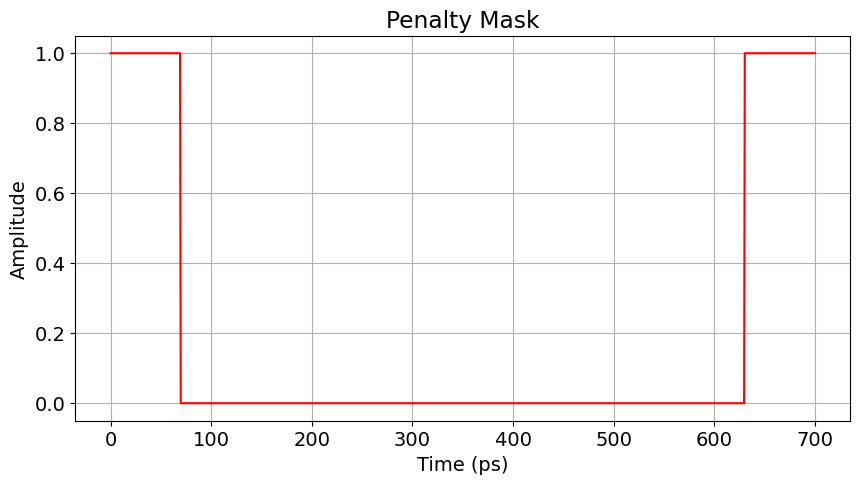

In [201]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [202]:
def forward(real, imag):
    Ain = reconstructA(real, imag)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(fft(Aev[:,-1])), target)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([real, imag], lr=lr)

### Train Model

In [203]:
losses = []

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(real, imag)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.17279841005802155
Iteration 50, Loss: 0.15755829215049744
Iteration 100, Loss: 0.14226946234703064
Iteration 150, Loss: 0.12793296575546265
Iteration 200, Loss: 0.11465959250926971
Iteration 250, Loss: 0.10241270810365677
Iteration 300, Loss: 0.09114580601453781
Iteration 350, Loss: 0.08084870129823685
Iteration 400, Loss: 0.0715058222413063
Iteration 450, Loss: 0.06307588517665863
Iteration 500, Loss: 0.055500417947769165
Iteration 550, Loss: 0.048715271055698395
Iteration 600, Loss: 0.0426558293402195
Iteration 650, Loss: 0.037259675562381744
Iteration 700, Loss: 0.032467521727085114
Iteration 750, Loss: 0.02822359837591648
Iteration 800, Loss: 0.024475565180182457
Iteration 850, Loss: 0.021174827590584755
Iteration 900, Loss: 0.01827617734670639
Iteration 950, Loss: 0.01573788933455944
Iteration 1000, Loss: 0.013521495275199413
Iteration 1050, Loss: 0.011591708287596703
Iteration 1100, Loss: 0.009916269220411777
Iteration 1150, Loss: 0.008465781807899475
Iterati

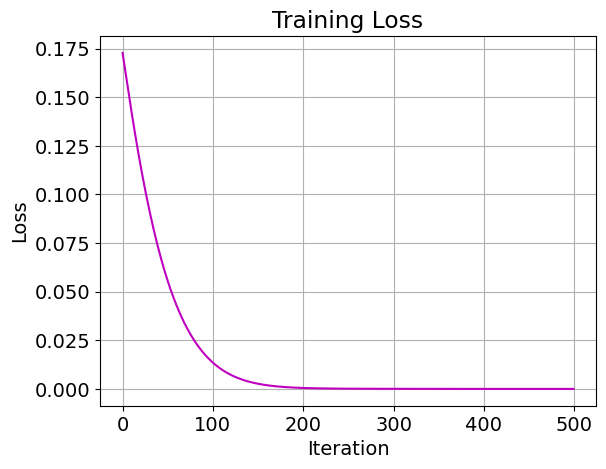

In [204]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

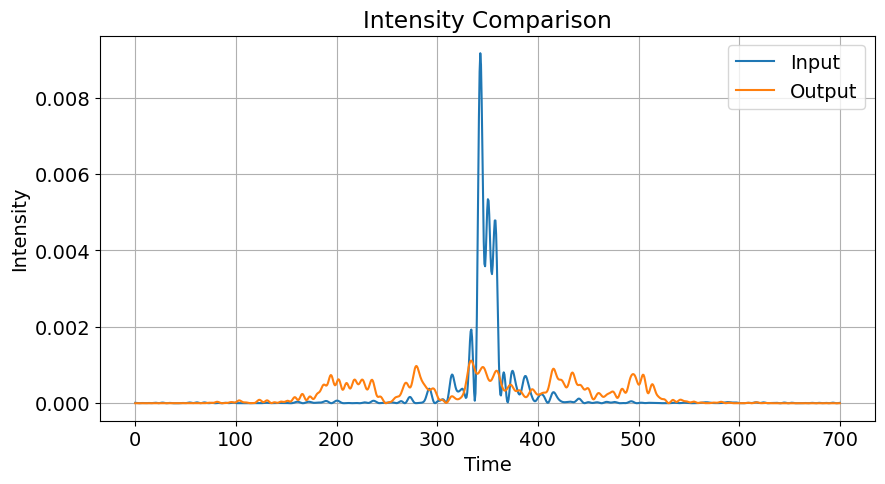

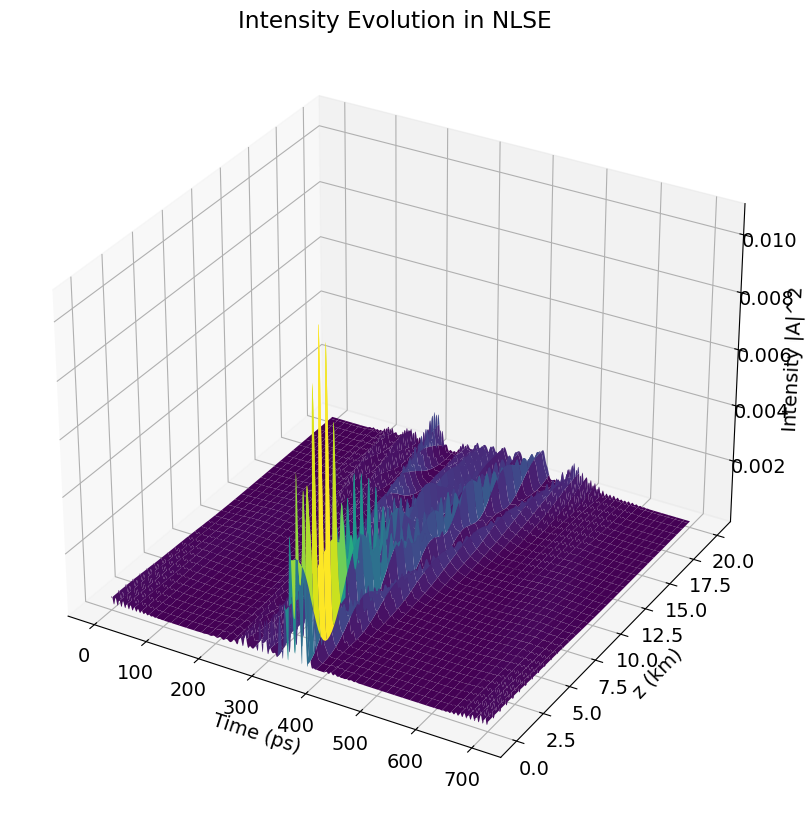

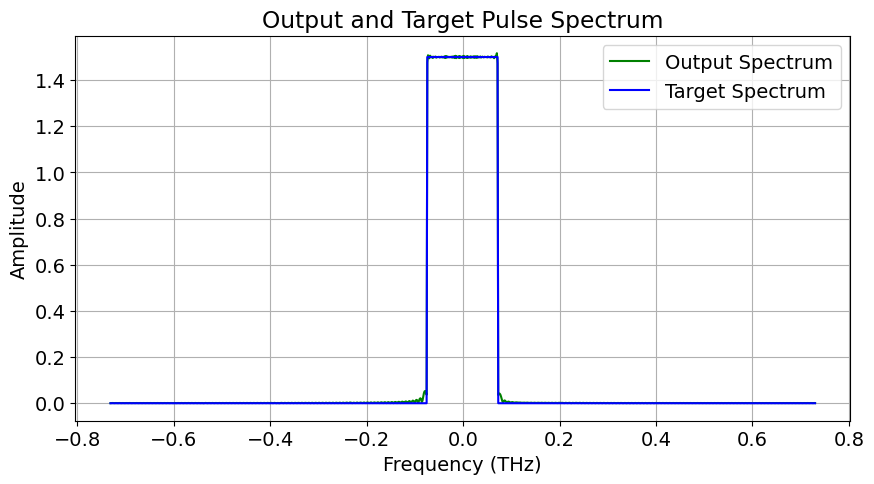

In [206]:
# plot comparison between input and output
Ain = reconstructA(real, imag)
Aout = Aev[:,-1]
plot_intensity_comparison(Ain, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectra
Aout_spectrum = torch.abs(fft(Aout))
plt.figure(figsize=(10, 5))
plt.plot(freqs, Aout_spectrum.detach().numpy(), color='green', label='Output Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Output and Target Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()

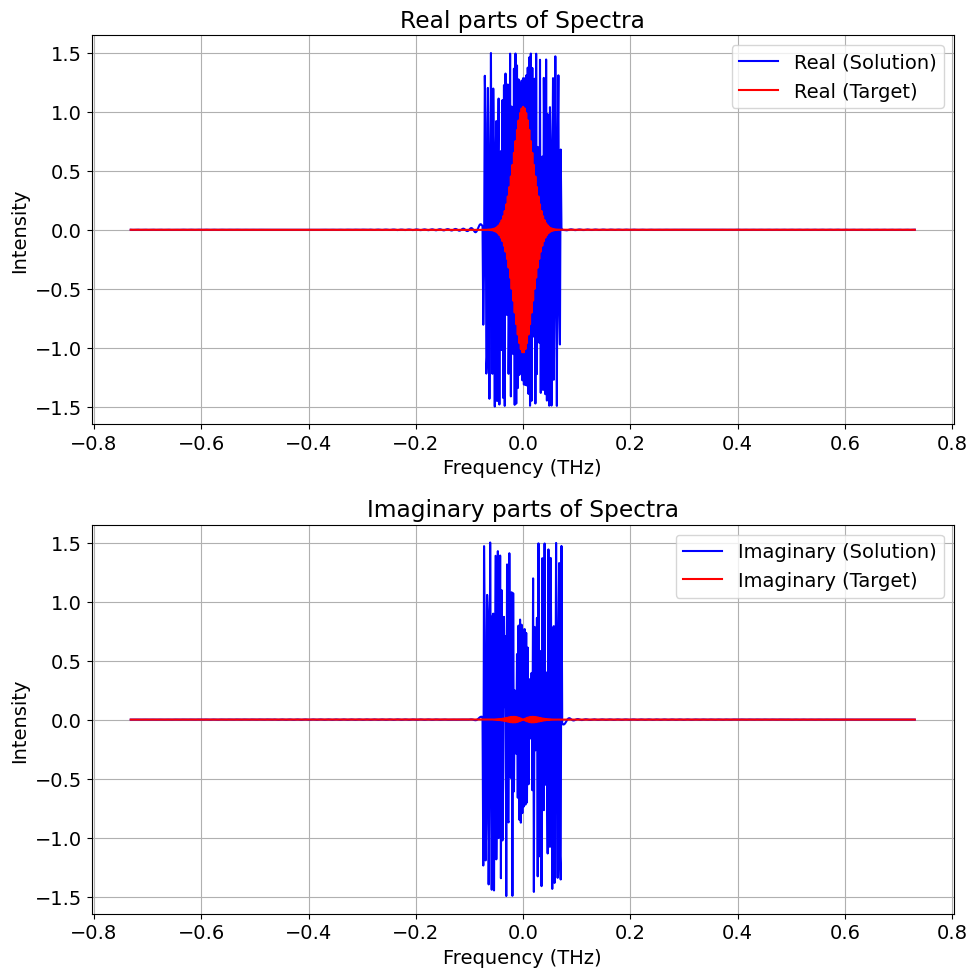

In [207]:
# define function to compare real and imaginary parts of two spectra (on two subplots for better visibility)
def plot_spectrum_comparison(A, B, freqs):
    As = fft(A).detach().numpy()
    Bs = fft(B).detach().numpy()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, As.real, color='blue', label='Real (Solution)')
    plt.plot(freqs, Bs.real, color='red', label='Real (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Real parts of Spectra')
    plt.grid()
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(freqs, As.imag, color='blue', label='Imaginary (Solution)')
    plt.plot(freqs, Bs.imag, color='red', label='Imaginary (Target)')
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Intensity')
    plt.title('Imaginary parts of Spectra')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
# plot comparison between real and imaginary parts of target and output spectra
plot_spectrum_comparison(Aout, expectation, freqs)

## Target Pulse 3: Frequency Domain—Square Wave (Complex Input)

Instead of having waveform in time domain as input use as the input the real and imaginary parts of the input waveform fourier transform (in hoped that this would give more direct access to the toggles we want the model to turn while also keeping somewat smooth and physical solutions).

### Define Parameters

In [83]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 700              # Temporal window size (ps)
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 5000
lr = 1e-3

w_mse = 1.0
w_pen = 1e10

# define constraints
m = 8 # how many waves to consider / penalize
mask_percent = 0.8 # percentage of the time window taken up by mask

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


# get frequencies for plotting
freqs = get_freqs(Nt, Lt) # get frequencies for plotting
# get time for plotting
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)


### Define Target

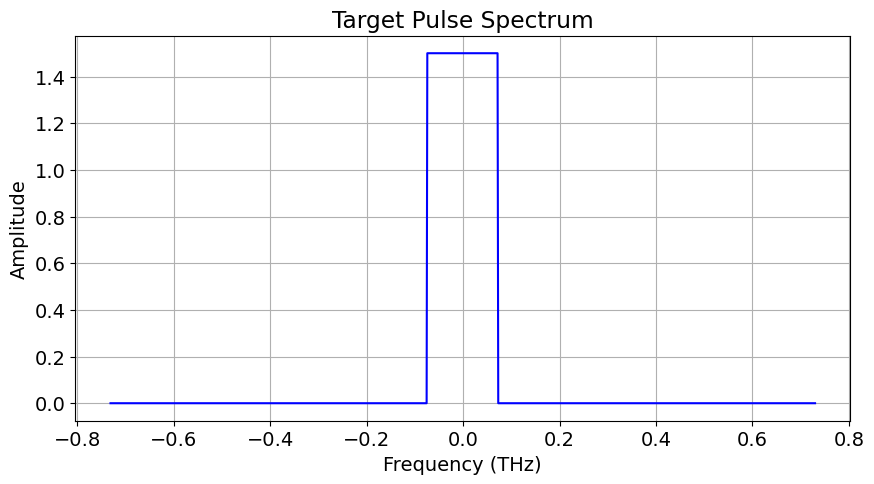

In [84]:
# define parameter of pulse
Amplitude = 1.5
width_percent = 0.1 # size in percent of the window size (frequency domain)

# define target pulse
target = torch.zeros(Nt)
target[int(Nt/2-Nt*width_percent/2):int(Nt/2+Nt*width_percent/2)] = 1
target = target * Amplitude

freqs = get_freqs(Nt, Lt) # get frequencies for plotting

# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, target, color='blue')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Target Pulse Spectrum')
plt.grid()
plt.show()


### Define Initial Guess and Mask
Initial Guess is the real and imaginary parts of a Gaussian FFT.

In [74]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.005                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = gaussian_pulse(t, center, T0, P0)
# cast to complex128
Ain_spectrum = fft(Ain).type(torch.complex128)

FFTin = torch.nn.Parameter(Ain_spectrum.clone().detach().requires_grad_(True))

### Define Useful Functions

In [75]:
def reconstructA(FFTin):
    return ifft(FFTin)

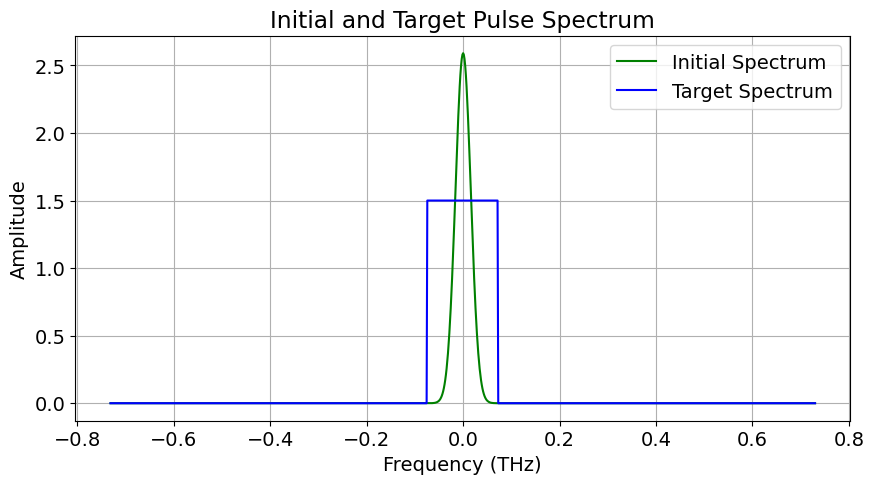

In [76]:
# plot initial pulse spectrum vs target spectrum
Ain_spectrum = fft(Ain)
# plot target pulse
plt.figure(figsize=(10, 5))
plt.plot(freqs, torch.abs(Ain_spectrum).detach().numpy(), color='green', label='Initial Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Initial and Target Pulse Spectrum')
plt.grid()
plt.legend()

### Define Penalty
Anything outside of initial mask gets penalized

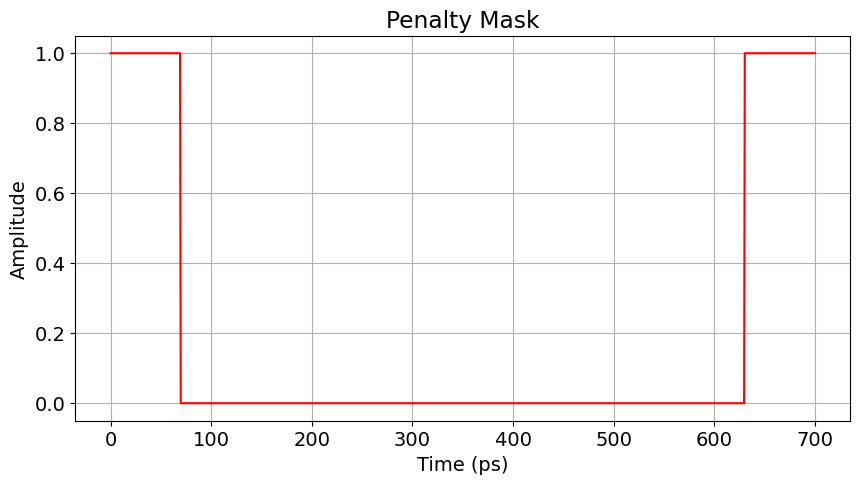

In [77]:
# define mask (so that pulse is periodic)
penalty = torch.zeros(Nt)
penalty[:int(Nt/2-Nt*mask_percent/2)] = 1
penalty[int(Nt/2+Nt*mask_percent/2):] = 1

# plot penalty
plt.figure(figsize=(10, 5))
plt.plot(t, penalty, color='r')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.title('Penalty Mask')
plt.grid()
plt.show()


### Define Model and Loss Function

In [78]:
def forward(FFTin):
    Ain = reconstructA(FFTin)
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Aev):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(fft(Aev[:,-1])), target)
    
    pen_loss = 0
    for i in range(m):
        pen_loss = F.mse_loss(torch.abs(Aev[:, i]*penalty)**2, torch.zeros(Nt), reduction='sum')   
        
    # print("MSE Loss: ", mse_loss.item(), "effective loss: ", w_mse * mse_loss.item())
    # print("Penalty Loss: ", pen_loss.item(), "effective loss: ", w_pen * pen_loss.item())
    
    return w_mse * mse_loss + w_pen * pen_loss

optimizer = optim.Adam([FFTin], lr=lr)

### Train Model

In [79]:
losses = []

# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(FFTin)  # full forward pass
    
    loss = loss_function(Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.17279808223247528
Iteration 50, Loss: 0.15671513974666595
Iteration 100, Loss: 0.14102841913700104
Iteration 150, Loss: 0.1263682097196579
Iteration 200, Loss: 0.11287391930818558
Iteration 250, Loss: 0.1005304828286171
Iteration 300, Loss: 0.08927959948778152
Iteration 350, Loss: 0.07907718420028687
Iteration 400, Loss: 0.06987357884645462
Iteration 450, Loss: 0.061600904911756516
Iteration 500, Loss: 0.054184526205062866
Iteration 550, Loss: 0.04755142331123352
Iteration 600, Loss: 0.04163271561264992
Iteration 650, Loss: 0.03636409342288971
Iteration 700, Loss: 0.031685732305049896
Iteration 750, Loss: 0.02754216268658638
Iteration 800, Loss: 0.023881956934928894
Iteration 850, Loss: 0.020657509565353394
Iteration 900, Loss: 0.017824819311499596
Iteration 950, Loss: 0.015343326143920422
Iteration 1000, Loss: 0.01317572221159935
Iteration 1050, Loss: 0.011287792585790157
Iteration 1100, Loss: 0.00964822806417942
Iteration 1150, Loss: 0.00822850689291954
Iteration

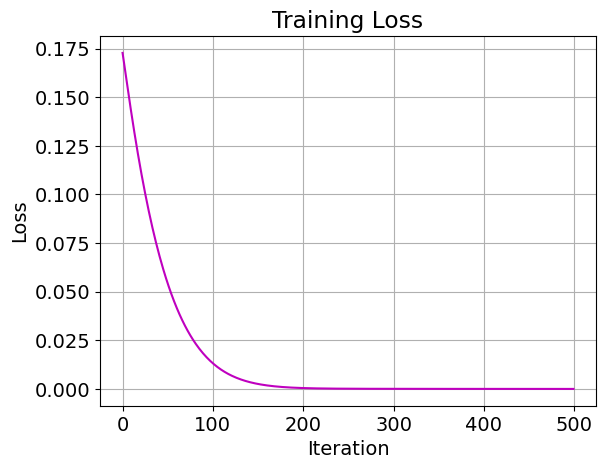

In [80]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

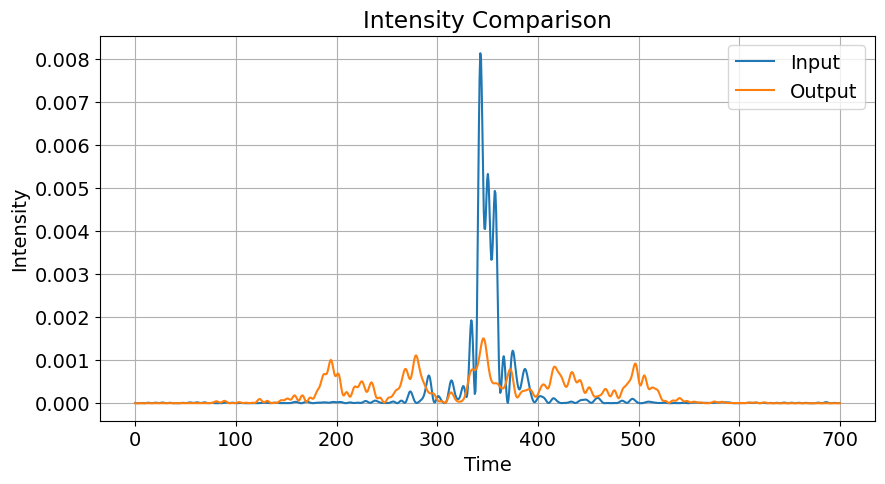

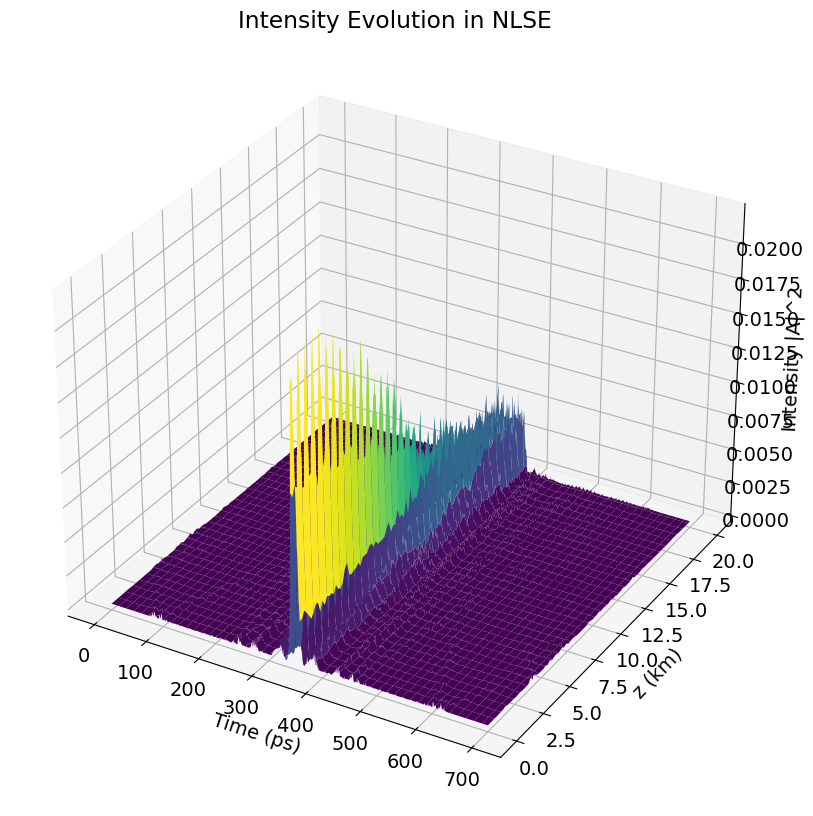

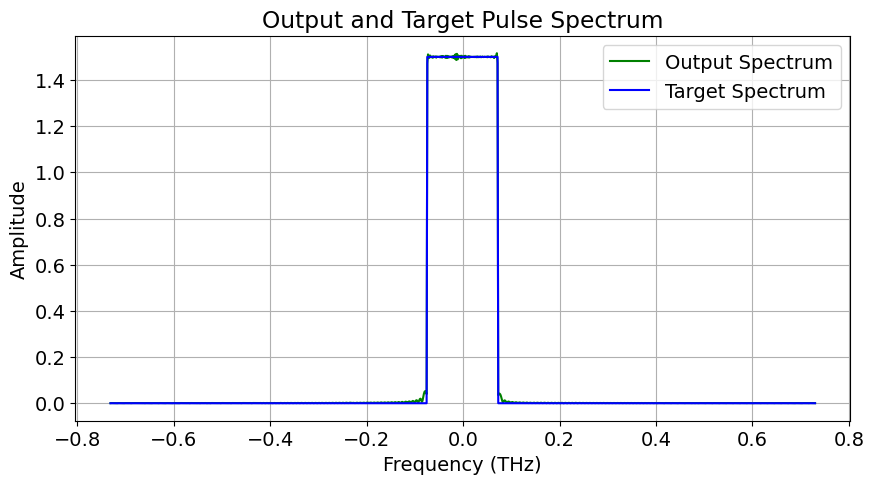

In [81]:
# plot comparison between input and output
Ain = reconstructA(FFTin)
Aout = Aev[:,-1]
plot_intensity_comparison(Ain, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

# plot spectra
Aout_spectrum = torch.abs(fft(Aout))
plt.figure(figsize=(10, 5))
plt.plot(freqs, Aout_spectrum.detach().numpy(), color='green', label='Output Spectrum')
plt.plot(freqs, target, color='blue', label='Target Spectrum')
plt.xlabel('Frequency (THz)')
plt.ylabel('Amplitude')
plt.title('Output and Target Pulse Spectrum')
plt.grid()
plt.legend()
plt.show()